# Simulation of Cooperative Agents

Version 8 - Added an integrator/delay to the agent decision model.

## Table of Contents

[Notes for using the code, log, etc](#notes)

[Load Results](#results)

[Figure 2: Trajectories](#fig_2)

[Figure 3: Coop, Antisynchrony analysis](#fig_3)

[Figure 4: Symmetry analysis, Parameter Distribution](#fig_4)

[Other analyses](#other_analyses)

[See the trajectories of solutions](#see_trajs)

[Analysis of the solutions](#analyses)



<a id='notes'></a>
## Notes for using the code

- The code uses multiprocessing module to distribute the optimization process between several workers. The number of workers can be modified using the n_workers variable in the [Constants](#constants) section.
- For the sake of efficiency, many variables (as defined in the constants section) are global and are used (only read, not modified) in various parts of the code. Hence, care must be taken while modifying them.
- With the modified EA algorithm (eaMuPLambda_ed), we're storing the pareto front (loss) of every generation in a variable. So if that's not necessary, just use plain eaMuPLambda and set the HallOfFame to ParetoFronts.


#### Log
- 





    
#### Add the following features:



#### Thoughts about the experiment and code



#### Hypothesizing about the analyses



#### Existing Issues


#### Unimportant issues


#### Code Improvements:

    
#### Notes


In [2]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import time
import pandas as pd
import numpy as np
import yaml #For parsing config files
import csv
import traceback
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from numpy.linalg import norm
from numpy import asarray as narr
import scipy as sp
from scipy.interpolate import interp1d

import datetime # For naming the directories
import sys, os

# For Creating a demo
# import matplotlib.animation as animation
import matplotlib.gridspec as gridspec#@@


import numdifftools as ndiff
# from scipy.stats import truncnorm

# For multiprocessing
import multiprocessing as mp

# For evolutionary search
from deap import creator, base, tools, algorithms
import random, copy
from numpy.random import randint

import datetime, pickle
import importlib # For reloading custom modules that have been modified

In [2]:
# For reloading modules, use importlib.reload.

# importlib.reload(visualizations)
# importlib.reload(custom_ea_modules)
import environment
importlib.reload(environment)
import analysis_funcs 
importlib.reload(analysis_funcs)

import helper_funcs, custom_ea_modules, trajectory_tools#visualizations, 
from trajectory_tools import Trajectory, rms
from helper_funcs import roots2ipd, ipd2roots, norm_sampler, rk4_step, trajectory_generator, traj_max_acc, ushaped_f, slide_f, sampler, bound
from custom_ea_modules import selElitistAndSUS, cxAvg_mixed, mut_mixed, ea_init_m_ones, ea_init_m, ea_init_m_guess, eaMuPLambda_ed, eaMuPLambda_popStats

from visualizations import pareto_visualizer, viz_coefs
from environment import egg_floating

from analysis_funcs import anti_synchrony, policy_symmetry, dyad_cooperation

In [3]:
###//////////////////////////////  Agent
class agents_bimodal_firing():
    
    # Global variables used:
    # n_w, traj_max_amp, tstep
    # import np, narr
    
    def map_params(paramset):
        # returns six lists: agent1w, agent2w
        # agentxw contains two list of weights each corresponding to a controller
        
        a1sw0 = paramset[:n_w]#np.zeros(n_w) #
        a1sw1 = paramset[n_w: 2*n_w]#np.zeros(n_w) #
        
        a2sw0 = paramset[2*n_w:3*n_w]#np.zeros(n_w) #
        a2sw1 = paramset[3*n_w: 4*n_w]#np.zeros(n_w) #
        agent1w = [stblrlist[int(paramset[n_w*4])], ctrlist[int(paramset[n_w*4+1])]]#[ctrlist[0],stblrlist[0]] #
        agent2w = [stblrlist[int(paramset[n_w*4+2])], ctrlist[int(paramset[n_w*4+3])]] #[ctrlist[0],stblrlist[0]] #
    
    
        return agent1w, agent2w, a1sw0, a1sw1, a2sw0, a2sw1
    
    
    def __init__(self, paramset):
     # w_max is the maximum angular frequency that the ref will have.
    
        self.agent1w, self.agent2w, self.a1sw1, self.a1sw0, self.a2sw1, self.a2sw0 = agents_bimodal_firing.map_params(paramset)
        
#         self.w_max = w_max
        
        self.a1role = 0; self.a2role = 0; # initial roles: both stabilize
        self.a1evidence = -1; self.a2evidence = -1; # evidence (as in diffusion decision model)
        self.ref_period = agent_decision_delay #refractory period in terms of time steps
        self.a1int = 0; self.a2int = 0;
#         self.a1int0 = 0; self.a1int1 = 0; 
#         self.a2int0 = 0; self.a2int1 = 0;
        
        
#         self.scaling_vec = [1., tstep, tstep**2, 1., tstep, tstep**2, traj_max_amp, traj_max_amp*tstep, traj_max_amp]
#         self.scaling_vec = [1., 1., 1., 1., 1., 1., 1, 1., 1]
    
    
    def reset(self):
        pass
#         self.cumError = 0
    
    
    def _update_roles(self, state1, state2): # Complete this method
        # state is a vector containing the current state of the task
        # It looks like np.array(ftr_r, ftr_p, traj_max_amp* ftr_normf, [traj_max_amp])
        
        # Toggle the role of agent 1 if necessary
        if self.a1int <=0: # If not in refractory period:...
            if self.a1role == 1:
                self.a1evidence = np.dot(self.a1sw0, state1)
                if self.a1evidence >0:
                    self.a1role = 0
                    self.a1int = self.ref_period

            elif self.a1role == 0:
                self.a1evidence = np.dot(self.a1sw1, state1)
                if self.a1evidence >0:
                    self.a1role = 1
                    self.a1int = self.ref_period

        elif self.a1int >0:
            self.a1int -=1

        
        # Toggle the role of agent 2 if necessary
        if self.a2int <=0: # If not in refractory period:...
            if self.a2role == 1:
                self.a2evidence = np.dot(self.a2sw0, state2)
                if self.a2evidence >0:
                    self.a2role = 0
                    self.a2int = self.ref_period

            elif self.a2role == 0:
                self.a2evidence = np.dot(self.a2sw1, state2)
                if self.a2evidence >0:
                    self.a2role = 1
                    self.a2int = self.ref_period

        elif self.a2int >0:
            self.a2int -=1
                    
        
        
    def generate_df(self, features, verbose=False):
        
        # Run the decision unit for one step and read the role from its output
        # Apply the appropriate controller given the role
    
        ftr_r, ftr_p, ftr_f1, ftr_f2 = features

#         norm_f = np.minimum(ftr_f1[0], ftr_f2[0])
        if ftr_f1[0]< ftr_f2[0]:
            ftr_normf = ftr_f1
        else:
            ftr_normf = ftr_f2
        
    
    # Make sure all features are in the scale of traj_max_amp. Special 
        inputs1 = np.concatenate((ftr_r, ftr_r-ftr_p, traj_max_amp*ftr_normf, [traj_max_amp]))
        inputs2 = np.concatenate((-ftr_r, -ftr_r+ftr_p, traj_max_amp*ftr_normf, [traj_max_amp]))
        
        
        self._update_roles(inputs1, inputs2)
        
#         self._update_roles(inputs1*self.scaling_vec , inputs2*self.scaling_vec)
    
        dforce1 = np.dot(self.agent1w[self.a1role], inputs1)#@@@@@@@@@@
        dforce2 = np.dot(self.agent2w[self.a2role], inputs2)#@@@@@@@@@@
        
#         print('self.agent1w = ' , self.agent1w[self.a1role])
#         print('inputs1 = ', inputs1)
        if verbose:
            return (dforce1, dforce2, inputs1)
        return (dforce1, dforce2)


<a id='controllers'></a>
#### Controllers
[Go to Manual testing](#manual_test)

In [4]:
###//////////////////////////////  Constants
# print('Reached Constants')
# **** Force bounds and gains **** 
dotf_bound = 400. #0.4 #0.8
f_bound = 100. #3.
#Egg constants
# egg_mass = 0.05

egg_mass = 0.5
egg_fric = 2*egg_mass #b as in f = bv

egg_single_step_penalty = 1. # The egg_bnd (normal force bounds) is set in the bottom, after calculating the forces.

HUMAN_LOSS = 0.35 # The common tracking loss for a human, after learning the task. Used in producing trkloss.

brkloss_coef = 1
egg_ub = 1; egg_lb = 0.1
traj_max_amp = 0.15*3


map_w_gain = 1. #30. #0.075 #?????????
# map_th_range = [-1.5*traj_max_amp, 1.5*traj_max_amp]#[-5, 5]#[, f_bound]


# **** Time-related Variables **** 
tstep = 0.025 
duration = 15 #25
agent_decision_delay = 10

sample_interval = tstep 
sim_stop_loss = 2*duration/tstep #duration/tstep # The simulation ends if the normal force is say, at 0 for this long.


# **** Parameter vector organization ****
# n_features = 3; 
n_rsamples = 3;
n_fsamples = 2;
n_regimes = 2;
n_agents = 2;



n_switch = n_agents*n_regimes #number of controllers
role_labels = ['Role0: Force Balancing', 'Role 1: Tracking']
ctr_labels = ['A1Sw0', 'A1Sw1', 'A2Sw0', 'A2Sw1']
ftr_names = ['r', 'r\'', 'r\"', 'e', 'e\'', 'e\"', 'f', 'f\'', 'c']
ftr_labels = n_switch*ftr_names


n_w = len(ftr_names) #int(n_samples*n_features+1) #+1 is the constant
n_floatparam = n_switch*n_w
n_params = n_floatparam +n_switch # +n_switch: each switch introduces a new controller

ftr_labels2 = copy.deepcopy(ftr_labels)
for i, _ in enumerate(ftr_labels2):
    if i%(2*n_w)<n_w:
        ftr_labels2[i]+='1'
    else:
        ftr_labels2[i]+='2'
# if len(ftr_labels) != n_params:
#     raise ValueError('Either the feature labels, or the n. params is incorrect!')

n_objectives = 5
ea_weights = (-1., -0.5, -5., -5., -50.)
if len(ea_weights) !=n_objectives:
    raise ValueError
# Initialization specs

ea_init_f = ea_init_m# ea_init_m_ones#ea_init_2#ea_init_m_guess #



# Guesses for the initialization of parameters
ic_rand1 = [0.5]*n_floatparam +[0]*n_switch
ic_rand2 = [0.5]*n_floatparam +[1]*n_switch

switchCondpos = [0,0,0, 0,1,0, 0, 0, -0.1]
switchCondneg = [0,0,0, 0,-1,0, 0, 0, -0.1]

ic1 = switchCondpos +switchCondneg +switchCondneg +switchCondpos +[0,0,0,0]

guesses = [ic1] # guesses are not used if ea_init_f = ea_init_m_ones
init_sig = 0.2

for item in guesses:
    if len(item)!= n_params:
        raise ValueError('guesses is not set correctly')
# A controller is a list of weights that will be multiplied by the feature vector.
# ['r', 'r\'', 'r\"', 'x', 'x\'', 'x\"', 'f', 'f\'', 'c']


ctrlr1 = [0. , 0. , 0. , 121.90, 62.95 , 1. , 0., 0., 0.] # small overshoot. 
# Poles at [-1-3.5j*pi -1+3.5j*pi -2] 
ctrlr2 = [0. , 0. , 0. , 46.41 , 15.60 , 2. , 0., 0., 0.] # medium overshoot. 
# Poles at [-1-1.5j*pi -1+1.5j*pi -4] 
ctrlr3 = [0. , 0. , 0. , 4. , 6. , 2. , 0., 0., 0.] # a bit slow. 
# Poles at [-2 -2 -2] 
ctrlr4 = [0. , 0. , 0. , 1.5 , 3.25 , 1.25 , 0., 0., 0.] # Slower. 
# Poles at [-2 -1.5 -1.] 

ctrlr5 = [0., 0.,  0., 32.608, 11.434,  3.0, 0., 0., 0.]


# Evolved from random with maximum of 100.
# ctrlr5 = [0., 0.,  0., 1.149, 16.482,  9.001, 0., 0., 0.] # Always keeps cursor to the left of the target
# Poles at [-18.19,  -1.73,  -0.0729]
ctrlr6 = [0., 0. , 0. , 7.352, 25.59 , 28.78 , 0., 0., 0.] # Takes a bit of time to follow well
# Poles at[-58.69, -0.43+0.249j, -0.433-0.249j]
ctrlr7 = [0., 0.,  0., 15.284, 17.612,  2.877, 0., 0., 0.] # Similar to ctrlr2
# Poles at [-3.33+4.10j -3.33-4.10j -1.09]

f_opt = 0.4
stblr1 = [0., 0., 0., 0., 0., 0., -1.*10, 0., f_opt*10] # fastest
stblr2 = [0., 0., 0., 0., 0., 0., -8, 0., f_opt*8] #
stblr3 = [0., 0., 0., 0., 0., 0., -1*4, 0., f_opt*4] # slowest
stblr4 = [0., 0., 0., 3., 0., 0., -1*8, 0., f_opt*8] # With a bit of tracking
stblr5 = [0., 0., 0., 0., 0., 0., -8, 0., f_opt*8] # copy of stblr2




# Mapping params to weight
param2w = interp1d([0,1], [-map_w_gain, map_w_gain], 
                    bounds_error=False, fill_value=(-map_w_gain, map_w_gain))
w2param = interp1d([-map_w_gain, map_w_gain],[0,1],
                   bounds_error=True, fill_value=(0, 1))
param2ctr = None # Just index the ctrlist
ctrlist = [ctrlr1, ctrlr2, ctrlr3, ctrlr4, ctrlr5] # A list of prespecified controllers
stblrlist = [stblr1, stblr2, stblr3, stblr4, stblr5]

n_ctrlr_types = len(ctrlist) # The different kinds of controllers we have among the options



# er_init_d = (0, 2*n_samples, 0.25, 0.1)     # (start_idx, end_idx, mu, sigma)
# f_init_d = (2*n_samples, n_features*n_samples, 0.5, 0.2)


# Reference Trajectory
traj_max_amp = traj_max_amp
rel_amps = [0.3, 0.6, 0.6, 0.4, 0.4]; amp_sum = np.sum(rel_amps)
rel_amps = [item/amp_sum for item in rel_amps]
n_refs = 3 # How many different trajectories do we want to include in training

traj_max_f = .5; w_max = 2*np.pi*traj_max_f

traj_obj = Trajectory(tstep=tstep, duration=duration)
traj_spec1 = traj_obj.generate_traj_spec(rel_amps, traj_max_amp, traj_max_f)
fc_req_max = traj_obj.get_max_force(traj_spec1, egg_mass, egg_fric)
egg_bnd = [fc_req_max/10, egg_ub] #[0.01, 0.2] #Note that ushaped_f() should be modified if the egg_bnd changes.
egg1 = egg_floating(egg_mass, egg_fric, egg_bnd, egg_single_step_penalty)
_f_l, _f_f = traj_obj.ideal_force_profile(traj_spec1, egg1, egg_bnd)
_ideal_rms = rms(_f_l, _f_f)
_ideal_fl_rms = rms(_f_l)
time1, traj = traj_obj.generate(traj_spec1)


T_SETTLE = 2. #The preparation time after which the trajectory reaches its normal amplitudes
n_workers = 5 # Number of processors used for computation


time1, trajs, traj_specs = traj_obj.generate_random(3, rel_amps, traj_max_amp, traj_max_f, egg1, egg_bnd, n_deriv=n_rsamples-1, ret_specs=True)

# Second iteration for setting the dependent variables: egg_bnd and trajs
fc_req_max = traj_obj.get_max_force(traj_specs[0], egg_mass, egg_fric)
egg_bnd = [egg_lb, egg_ub] #[0.01, 0.2] 
egg1 = egg_floating(egg_mass, egg_fric, egg_bnd, egg_single_step_penalty)
_f_l, _f_f = traj_obj.ideal_force_profile(traj_specs[0], egg1, egg_bnd)
_ideal_rms = rms(_f_l, _f_f)
_ideal_fl_rms = rms(_f_l)

time1, trajs, traj_specs = traj_obj.generate_random(3, rel_amps, traj_max_amp, traj_max_f, egg1, egg_bnd, n_deriv=n_rsamples-1, ret_specs=True)
traj_mask = slide_f(time1, T_SETTLE)
for i, traj in enumerate(trajs):
    traj = traj*traj_mask # Prepare the first second of the trajectory
    trajs[i] = traj
    
time2, test_traj, test_tr_specs = traj_obj.generate_random(1, rel_amps, traj_max_amp, traj_max_f, egg1, egg_bnd, n_deriv=n_rsamples-1, ret_specs=True)
test_traj = test_traj[0]
test_traj = test_traj*traj_mask  
    
    
    

In [5]:
#//////////////  simul function
    
    
def simul(paramset, verbose=False):
    # Global variables used:
    # trajs, egg1, time1, tstep, n_samples, sample_interval, sim_stop_loss, traj_max_amp
    # Imports:
    # np, narr, random, 
    # agents_l_2mod, sampler, bound
    
    ref_ptr = random.randrange(0, n_refs)
    traj = trajs[ref_ptr]
    egg1.reset()
    egg1.x = traj[0][0];
    c_agents = agents_bimodal_firing(paramset) 

    pos = np.zeros_like(time1)
#     pert = np.zeros_like(time1)
    f1 = np.zeros_like(time1)
    a1roles = np.zeros_like(time1)
    f2 = np.zeros_like(time1)
    a2roles = np.zeros_like(time1)
    
#     eta = 0.1

    # wlen = 5 #window length
    # ftr_pos = np.zeros(wlen);ftr_f1 = np.zeros(wlen);ftr_ref = np.zeros(wlen);
    # inputs = np.zeros(3*wlen)

#     wlen = int(n_rsamples*sample_interval/tstep) #window length
    ftr_ref = traj[0][0]*np.ones(n_rsamples);
    ftr_pos = traj[0][0]*np.ones(n_rsamples);
    ftr_f1 = f_opt*np.ones(n_fsamples); ftr_f2 = f_opt*np.ones(n_fsamples);
#     inputs = np.zeros(3*n_samples)
    features = ()#np.zeros((n_features+1)*n_samples)
#     inputs1 = np.zeros(n_features*n_samples+1);inputs2 = np.zeros(n_features*n_samples+1)

    force1 = f_opt; force2 = f_opt;
    dotf1 = 0.; dotf2 = 0.;
    jerk_ssum = 0; 
    early_stop = False

    for step, t in np.ndenumerate(time1):
        step=step[0]
        ftr_ref = traj[:, step]
        egg_acc = (egg1.net_f-egg1.fric*egg1.v)/egg1.mass
        ftr_pos = narr([egg1.x, egg1.v, egg_acc])
        ftr_f1 = narr([force1, dotf1])
        ftr_f2 = narr([force2, dotf2])

        ######################################
    
    # Generate the ouput of each agent, using the features.

        features = (ftr_ref, ftr_pos, ftr_f1, ftr_f2)
           
        dotf1, dotf2 = c_agents.generate_df(features)

        dotf1 = bound(dotf1, dotf_bound)
        force1 = bound(force1 +dotf1*tstep, f_bound)

        dotf2 = bound(dotf2, dotf_bound)
        force2 = bound(force2 +dotf2*tstep, f_bound)
                
        # ReLU on output
        if force1 <0:
            force1=0
        if force2 <0:
            force2=0
            
            
        ######################################
        # Update the egg dynamics and penalty
        
        # Recalculate df1 and df2 after the ReLU
        dotf1 = (force1-f1[step-1])/tstep; dotf2 = (force2-f2[step-1])/tstep
        egg1.update_penalty(force1, force2)
        egg1.update_state(dotf1-dotf2, t, tstep)
        
        

        # Save Data
        f1[step] = force1
        f2[step] = force2
        a1roles[step] = c_agents.a1role
        a2roles[step] = c_agents.a2role
        pos[step] = egg1.x
        
        jerk_ssum += (dotf1**2 + dotf2**2)*tstep
        
        if egg1.penalty >=sim_stop_loss:
            early_stop = True
#             egg1.cond = egg1.cond*time1[-1]/(t+1)
            break
    
#     if early_stop is True:
#         pass

    n_steps = int(t/tstep)
#     trkloss = np.linalg.norm(traj[wlen:]-pos[wlen:])/(traj_max_amp* np.sqrt(n_steps))

    trkloss = rms((traj[0,:n_steps]-pos[:n_steps])/traj_max_amp)
#     if trkloss < 2*HUMAN_LOSS:
#     trkloss = (trkloss - HUMAN_LOSS)**2 # Just make sure (trkloss - HUMAN_LOSS) is not >1 #*random.random() # beta test @@@@@@@@@@@@
    brkloss = egg1.penalty*brkloss_coef/n_steps #=0.1-10*egg1.cond/len(time1)
#     enrgloss = (np.linalg.norm(f1) + np.linalg.norm(f2))/np.sqrt(n_steps)
    enrg1loss = rms(f1[:n_steps])/100.
    enrg2loss = rms(f2[:n_steps])/100.
    jerkloss = (jerk_ssum/t)/(10000*egg1.mass)
    
    if early_stop is True and t<T_SETTLE:
        trkloss = 2. #max(trkloss, 2)
        
    # Additional Stats
    # Anti-synchrony
    anti_sync = anti_synchrony(a1roles, a2roles)
    # Symmetry
    # a1sw = np.concatenate((c_agents.a1sw0[:, np.newaxis], c_agents.a1sw1[:, np.newaxis]),axis=0)
    # a2sw = np.concatenate((c_agents.a2sw0[:, np.newaxis], c_agents.a2sw1[:, np.newaxis]),axis=0)
    a1sw = c_agents.a1sw0 + c_agents.a1sw1
    a2sw = c_agents.a2sw0 + c_agents.a2sw1
    symm_a1a2 = policy_symmetry(a1sw, a2sw)
    symm_a1a2sw0 = policy_symmetry(c_agents.a1sw0, c_agents.a2sw0)
    symm_a1a2sw1 = policy_symmetry(c_agents.a1sw1, c_agents.a2sw1)
    symm_a1sw0a2sw1 = policy_symmetry(c_agents.a1sw0, c_agents.a2sw1)
    symm_a1sw1a2sw0 = policy_symmetry(c_agents.a1sw1, c_agents.a2sw0)
    
    #Cooperation                            
    coop = dyad_cooperation(enrg1loss, enrg2loss)
    other_objs = [anti_sync, symm_a1a2, symm_a1a2sw0, symm_a1a2sw1, symm_a1sw0a2sw1, symm_a1sw1a2sw0, coop]
#     other_objs = {"async": anti_sync,
#                   "symm": [symm_a1a2, symm_a1a2sw0, symm_a1a2sw1, symm_a1sw0a2sw1, symm_a1sw1a2sw0],
#                   "coop": coop}
    
    if verbose:
        return time1, f1, f2, pos, traj[0,:]
    else:
        return ((trkloss, brkloss, enrg1loss, enrg2loss, jerkloss), other_objs)
    
    
def evalState(paramset):
    # Run the simulation using the weights
    return simul(paramset)



#//////////// Evolutionary Search

# Hyperparameters
n_params = n_params 

popsize = 500; 
mutpb = max(0.05, 1/popsize)
eta = 10; # For the mutation
cxpb = 1-mutpb #0.9;

algo = eaMuPLambda_ed #algorithms.eaMuPlusLambda; 
mu = popsize; lambda_ = 2*popsize;

# Objective function


# Set up the problem
creator.create("MultiFitnessMin", base.Fitness, weights=ea_weights)
creator.create("Individual", list, fitness=creator.MultiFitnessMin, other_attrs=list)
#creator.create("Individual", list, fitness=creator.MultiFitnessMin)


toolbox = base.Toolbox()

# toolbox.register("individual", ea_init_f, creator.Individual, n_params, *ftr_modules)
toolbox.register("individual", ea_init_f, creator.Individual, n_params, n_floatparam, n_ctrlr_types)
# toolbox.register("individual", ea_init_f, creator.Individual, n_params, n_floatparam, guesses, init_sig, n_ctrlr_types)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the essential operators of the toolbox
toolbox.register("evaluate", evalState)
toolbox.register("mate", cxAvg_mixed, idx=n_floatparam)
# toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", mut_mixed, eta=eta, low1=-1., up1=1., indpb=0.2, idx=n_floatparam)
# toolbox.register("mutate", tools.mutPolynomialBounded, eta=eta, low=0, up=1., indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Specify Stats for recording the results
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("FitnessStd", np.std, axis=0)
stats.register("FitnessBest", np.min, axis=0)


In [6]:
def simultest(players, verbose=True):
    # Global variables used:
    # egg1, tstep, n_samples, sample_interval, traj_max_amp, sim_stop_loss
    # Imports:
    # np, narr, random, 
    # agents_l_2mod, sampler, bound, trajectory_generator
    
    simtraj = test_traj
    egg1.reset()
    egg1.x = simtraj[0][0]; 
    
    if hasattr(type(players), '__iter__'):
        c_agents = agents_bimodal_firing(players) 
    else:
        c_agents = players

    pos = np.zeros_like(time2)
#     pert = np.zeros_like(time2)
    f1 = np.zeros_like(time2)
    role1 = np.zeros_like(time2)
    evidence1 = np.zeros_like(time2)
    f2 = np.zeros_like(time2)
    role2 = np.zeros_like(time2)
    evidence2 = np.zeros_like(time2)
    
#     eta = 0.1

    # wlen = 5 #window length
    # ftr_pos = np.zeros(wlen);ftr_f1 = np.zeros(wlen);ftr_ref = np.zeros(wlen);
    # inputs = np.zeros(3*wlen)

#     wlen = int(n_rsamples*sample_interval/tstep) #window length
    ftr_ref = simtraj[0][0]*np.ones(n_rsamples);
    ftr_pos = simtraj[0][0]*np.ones(n_rsamples);
    ftr_f1 = f_opt*np.ones(n_fsamples); ftr_f2 = f_opt*np.ones(n_fsamples);
    
    ftr_vecs = []
#     inputs = np.zeros(3*n_samples)
    features = ()#np.zeros((n_features+1)*n_samples)
#     inputs1 = np.zeros(n_features*n_samples+1);inputs2 = np.zeros(n_features*n_samples+1)

    force1 = f_opt; force2 = f_opt; 
    dotf1 = 0.; dotf2 = 0.; 
    jerk_ssum = 0.
    early_stop = False

    for step, t in np.ndenumerate(time2):
        step=step[0]     
        ftr_ref = simtraj[:, step]
        egg_acc = (egg1.net_f-egg1.fric*egg1.v)/egg1.mass
        ftr_pos = narr([egg1.x, egg1.v, egg_acc])
        ftr_f1 = narr([force1, dotf1])
        ftr_f2 = narr([force2, dotf2])

        ######################################
    
    # Generate the ouput of each agent, using the features.

        features = (ftr_ref, ftr_pos, ftr_f1, ftr_f2)
           
        dotf1, dotf2 = c_agents.generate_df(features)

        dotf1 = bound(dotf1, dotf_bound)
        force1 = bound(force1 +dotf1*tstep, f_bound)

        dotf2 = bound(dotf2, dotf_bound)
        force2 = bound(force2 +dotf2*tstep, f_bound)
                
        # ReLU on output
        if force1 <0:
            force1=0
        if force2 <0:
            force2=0
            
            
        ######################################
        # Update the egg dynamics and penalty
        
        # Recalculate df1 and df2 after the ReLU
        dotf1 = (force1-f1[step-1])/tstep; dotf2 = (force2-f2[step-1])/tstep
        egg1.update_penalty(force1, force2)
        egg1.update_state(dotf1-dotf2, t, tstep)
        
        # Save Data
        f1[step] = force1
        f2[step] = force2
        role1[step] = c_agents.a1role
        role2[step] = c_agents.a2role
        evidence1[step] = c_agents.a1evidence
        evidence2[step] = c_agents.a2evidence
        pos[step] = egg1.x
        
        jerk_ssum += (dotf1**2 + dotf2**2)*tstep
        
#         sim_stop_loss = max(t, T_SETTLE)/tstep
        if egg1.penalty >=sim_stop_loss and verbose is False:
            early_stop = True
            break

    n_steps = int(t/tstep)
    trkloss = rms((simtraj[0,:n_steps]-pos[:n_steps])/traj_max_amp)
#     trkloss = (trkloss - HUMAN_LOSS)**2
    brkloss = egg1.penalty*brkloss_coef/n_steps #egg1.penalty*brkloss_coef/n_steps 
    enrg1loss = rms(f1[:n_steps])/100.
    enrg2loss = rms(f2[:n_steps])/100.
    jerkloss = (jerk_ssum/t)/(10000*egg1.mass)
    
    if early_stop is True and t<T_SETTLE:
        trkloss = 2. #max(trkloss, 2)
          
        
    if verbose:
#         print(trkloss, brkloss, enrg1loss, enrg2loss, jerkloss)
        return time2, f1, f2, role1, role2, evidence1, evidence2, pos, simtraj[0,:], ftr_vecs
    else:
        return trkloss, brkloss, enrg1loss, enrg2loss, jerkloss

<a id='manual_test'></a>
### Manually create and test controllers

[Go to controllers](#controllers)

In [10]:
# tmp_ind = ea_init_m_ones(list, n_params, n_floatparam, n_ctrlr_types)
i=-7
sol = list(hoffparams[plt_sol[i]])+ list(hofctrs[plt_sol[i]])
tmp_ind = sol
tmp_agent = agents_bimodal_firing(tmp_ind)

# switchCondpos = narr([0,0,0, 0,1,0, 0, 0, -0.1])
# switchCondneg = narr([0,0,0, 0,-1,0, 0, 0, -0.1])
# # switchCondpos = narr([0,0,0, 0,0,1, 0, 0, -0.005])#/tstep])
# # switchCondneg = narr([0,0,0, 0,0,-1, 0, 0, -0.005])#/tstep])
# switchCondpos /= norm(switchCondpos)
# switchCondneg /= norm(switchCondneg)

# tmp_agent.a1sw1 = switchCondpos;
# tmp_agent.a1sw0 = switchCondneg;
# tmp_agent.a2sw1 = switchCondpos;
# tmp_agent.a2sw0 = switchCondneg;

# # stblr_test = [0., 0., 0., 0., 0., 0., -1*10, 0., f_opt*10] 
# # K = 10
# # stblr_test = [0., -egg1.fric*K, -egg1.mass*K, 0.,egg1.fric*K, egg1.mass*K, -1*K, 0., f_opt*K] # slowest

# pid1 = stblr2#[0., 0., 0., -0., 0., 0., -2, 0., 1.*2]
# pid2 = ctrlr3

# tmp_agent.agent1w = [pid1, pid2]
# tmp_agent.agent2w = [pid1, pid2]


tmp_agent.a1role =1
tmp_agent.a2role =0


tt1, xf1, xf2, xrl1, xrl2, xev1, xev2, xpos, xref, ftr_vecs = simultest(tmp_agent, verbose=True) #simul(ctr, verbose=True)#
print('Loss = ', simultest(tmp_agent, verbose=False))
fig, ax = plt.subplots(2,3, figsize=(15,3))

t_win = int(len(tt1)/16); pltslc = slice(t_win*0,t_win*(-1))
#     ax[i].plot(time1, 5*xf1, label='5*force')
ax[0,0].plot(tt1[pltslc], xref[pltslc], label='ref')
ax[0,0].plot(tt1[pltslc], xpos[pltslc], label='pos')
ax[0,1].plot(tt1[pltslc], xf1[pltslc], label='force1')
ax[0,1].plot(tt1[pltslc], xf2[pltslc], label='force2')
ax[0,1].axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f- bounds')
ax[0,1].axhline(y=egg_bnd[1], ls=':', color='k')

ax[1,1].plot(tt1[pltslc], np.minimum(xf1,xf2)[pltslc])#, label='normal force')
ax[1,1].axhline(y=egg_bnd[0], ls=':', color='k')#,  label='normal f- bounds')
ax[1,1].set_ylim((0, 8))

ax[1,0].plot(tt1, xref-xpos, label='error')
ax[0,2].plot(tt1[pltslc], xev1[pltslc], label='Agent 1 Evidence')
ax[0,2].plot(tt1[pltslc], xev2[pltslc], label='Agent 2 Evidence')
ax[0,2].axhline(y=0, c='k', ls='--')
ax[1,2].plot(tt1[pltslc], xrl1[pltslc], label='Agent 1 role')
ax[1,2].plot(tt1[pltslc], xrl2[pltslc], label='Agent 2 role')

# for _,axij in np.ndenumerate(ax):
#         axij.legend(); axij.set_xlabel('Time')
        
print('Number of time steps where normal force is violated: ', 
      np.sum(np.minimum(xf1,xf2)<egg_bnd[0]) +
      np.sum(np.minimum(xf1,xf2)>egg_bnd[1]))

NameError: name 'hoffparams' is not defined

In [221]:
simultest(tmp_agent, verbose=False) #simul(ctr, verbose=True)#

(0.3564807862951195,
 0.16343054563991,
 0.008695772455669734,
 0.008575396630134924,
 0.0007940766516010845)

<a id='results'></a>
## Load data

In [7]:
from os import listdir
from os.path import isfile, join
import pandas as pd


In [8]:
selected_date = 'Oct20'
# selected_date = 'Oct203'

In [9]:
pop_path = 'data/'+selected_date+'/pop_stats'
sgen_path = 'data/'+selected_date+'/select_gens'
hof_path = 'data/'+selected_date+'/hof'

pop_files = [join(pop_path, f) for f in listdir(pop_path) if isfile(join(pop_path, f))]

popdata = []
for file_i in pop_files:
    popdata.append(np.load(file_i))
    
    

In [10]:
sgen_path = 'data/'+selected_date+'/select_gens'
sgen_files = [join(sgen_path, f) for f in listdir(sgen_path) if isfile(join(sgen_path, f))]

sgendata = []
for file_i in sgen_files:
    with open(file_i, 'rb') as data_file:
        sgendata_i = pickle.load(data_file)
        sgendata.append(sgendata_i)
    
    

In [11]:
final_pops = []
for pop in sgendata:
    final_pops+=pop[-1]

In [12]:
# Crate an equivalent of hoffparams and hofloss for popdata
popparams = []
popobj = []
for ind in final_pops:
    popparams.append(narr(ind[:-4]))
    popobj.append(narr(list(ind.fitness.values)+ind.other_attrs))
    
popparams = narr(popparams)
popobj = narr(popobj)

<a id='fig_2'></a>
## Figure 2: Solution Trajectories

In [173]:
# Fig 2
# Pick the proper dyad from each generation to show traces.

run_num =5
popdata[5].shape

select_inds = []
for gen in gen_nums:
    inds = popdata[run_num][gen, ...]
    for i in range(inds.shape[0]):
        if inds[i,0]+inds[i,1] >2 and inds[i,0]+inds[i,1] <10:
            print('gen=', gen, 'ind=',i)
#             break

gen= 1 ind= 4
gen= 1 ind= 9
gen= 1 ind= 10
gen= 1 ind= 21
gen= 1 ind= 53
gen= 1 ind= 84
gen= 1 ind= 95
gen= 3 ind= 33
gen= 3 ind= 62
gen= 3 ind= 94
gen= 10 ind= 9
gen= 30 ind= 5
gen= 30 ind= 7
gen= 30 ind= 13
gen= 30 ind= 52


In [235]:
# Fig 1
run_num =5
gen_nums = [1,3,10,30]
# gen_nums = [1,2,5,10]
ind_num = [2, 62, 4, 42] #[2, 33, 4, 42]

sols = []
for i in range(len(gen_nums)):
     sols.append(list(sgendata[run_num][i][ind_num[i]]))

In [22]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('medium')

In [32]:
# Define fonts
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = SMALL_SIZE



Loss=  (57.50804165105234, 0.04713739665001398, 0.003992757716791809, 0.04020527096478718, 0.0008263958305686387)
Loss=  (0.10950201732604219, 1.611106828337868, 0.01626477445513643, 0.017862247908697122, 0.001982230955992437)
Loss=  (0.13688122899834115, 0.7970938582249796, 0.012113796710385524, 0.008583054342552403, 0.003744930264763532)
Loss=  (0.09882949814084153, 0.09044749042635487, 0.013399912739403158, 0.011589605331495771, 0.0018148915871346457)


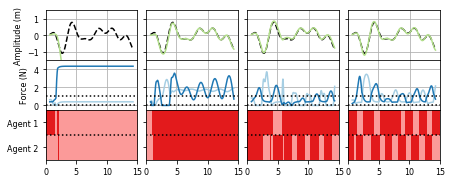

In [373]:
### Make the new figures

# Define colors
REF = 'k'
POS = cm.Paired(2)
ROLE_S = cm.Paired(4)
ROLE_T = cm.Paired(5)
AGENT1 = cm.Paired(0)
AGENT2 = cm.Paired(1)
#imshow cmap
roles_cm = LinearSegmentedColormap.from_list(
    'roles_cm', [ROLE_S, ROLE_T], N=2)

n_row = 3; n_col = len(gen_nums)
#row1: ref, pos
#row2: forces
#row3: roles
fig, ax = plt.subplots(n_row,n_col, figsize=(7.0625, 2.75), sharey='row')

chosen_sols = sols

for j in range(n_col):
    sol = chosen_sols[j]
    print('Loss= ', simultest(sol, verbose=False))
#     print('solution ',i, ' = ', sol)
    tt1, xf1, xf2, xrl1, xrl2, xev1, xev2, xpos, xref, ftr_vecs = simultest(sol, verbose=True)
#     xrl1_spans = get_swSpans(xrl1); xrl2_spans = get_swSpans(xrl2)
    
    
    t_win = int(len(tt1)/16); pltslc = slice(t_win*1,t_win*(-1))
#     ax[i].plot(time1, 5*xf1, label='5*force')
    l1 = ax[0,j].plot(tt1[pltslc], xref[pltslc], label='ref', ls='--',c=REF)
    l2 = ax[0,j].plot(tt1[pltslc], xpos[pltslc], label='cursor pos', c=POS)
    ax[0,j].grid(True)
    l3 = ax[1,j].plot(tt1[pltslc], xf1[pltslc], c=AGENT1, label='Agent 1')
    l4 = ax[1,j].plot(tt1[pltslc], xf2[pltslc], c=AGENT2, label='Agent 2')
    l5 = ax[1,j].axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f- bounds')
    ax[1,j].axhline(y=egg_bnd[1], ls=':', color='k')
    ax[1,j].grid(True)
    
    l6 = ax[2,j].imshow(narr([xrl1, xrl2]), extent = [0, tt1[-1], -0.5, 1.5], aspect='auto', cmap=roles_cm)
    ax[2,j].axhline(y=0.5, c='k', ls=':')

    
#     plt.tight_layout()
    
#     for _,axij in np.ndenumerate(ax):
plt.subplots_adjust(wspace=0.1, hspace=0)

# ax[0,0].legend(); ax[1,0].legend();
_ = ax[0,0].set_ylim(-1.5,1.5)
_ = ax[1,0].set_ylim(-0.5,5)
_ = ax[2,0].set_ylim(-0.5,1.5)

# Set y labels
ax[0,0].set_ylabel('Amplitude (m)')
ax[1,0].set_ylabel('Force (N)')
ax[2,0].set_yticklabels(['','Agent 2', 'Agent 1',''])

# Set title
# for i in range(len(gen_nums)):
#     ax[0,i].set_title('Gen '+str(gen_nums[i]))

    


handles, labels=[],[]
# for _,axij in np.ndenumerate(ax):
#     hd, lb = axij.get_legend_handles_labels()
for i in range(n_row-1):
    hd, lb = ax[i,0].get_legend_handles_labels()
    handles+=hd; labels+=lb

    
rl_vals = [0,1]
rl_lbls = ['Role S', 'Role T']

rl_cs = [ roles_cm(value) for value in rl_vals]
# create a patch (proxy artist) for every color 
rl_patches = [ mpatches.Patch(color=rl_cs[i], label=rl_lbls[i] ) for i in range(len(rl_vals)) ]
    
handles+=rl_patches; labels+=rl_lbls
# fig.legend(handles, labels, prop=fontP, loc='lower center', bbox_to_anchor=(0.5, -.05))

# plt.savefig('Fig1-traces.pdf', dpi=600)
# put those patched as legend-handles into the legend
# plt.legend(handles=rl_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

#     fig.legend((l1,l2))
#     ax[2,j].set_ylim([-1,1])
#     for span in xrl1_spans:
#         ax[2,j].axvline(x=span[0], ymin=0.5, linewidth=span[1], color=cm.tab10(span[2]))
#     for span in xrl2_spans:
#         ax[2,j].axvline(x=span[0], ymax=0.5, linewidth=span[1], color=cm.tab10(span[2]))

<a id='fig_3'></a>
## Figure 3: Coop vs Loss, Antisynchrony vs Loss

In [199]:
# Load HallOfFame Data




# pareto_files = [join(pareto_path, f) for f in listdir(pareto_path) if isfile(join(pareto_path, f))]

hof_path = 'data/'+selected_date+'/hof'
hof_files = [join(hof_path, f) for f in listdir(hof_path) if isfile(join(hof_path, f))]

# filt_lims = (0.7, 0.3*brkloss_coef, np.inf, np.inf, np.inf) #(0.3, 0.2, np.inf, 50)
filt_lims = (1.9, 3*brkloss_coef, np.inf, np.inf, np.inf) #(0.3, 0.2, np.inf, 50)
# filt_up = (0.1)


        
hofcat = np.empty((1, n_params+n_objectives), dtype=float)
for i, file_i in enumerate(hof_files):
    print('Opening ',i,'th file.')
    with open(file_i, 'rb') as data_file:
        hof_data_i = pickle.load(data_file)
        hofloss = narr([list(ind.fitness.values) for ind in hof_data_i])
        hoffparams = narr([list(ind[:n_floatparam]) for ind in hof_data_i])
        hofctrs = narr([list(ind[n_floatparam:]) for ind in hof_data_i], dtype=int)        
        hofcat_i = np.concatenate((hoffparams, hofctrs, hofloss), axis=1)
        k=0; 
        while k <hofcat_i.shape[0]:
            if hofcat_i[k, -5]> filt_lims[0] or hofcat_i[k, -4]>filt_lims[1]:
                hofcat_i = np.delete(hofcat_i, k, 0)
            else:
                k+=1
#         n_sols = hofcat_i.shape[0]
        hofcat = np.concatenate((hofcat, hofcat_i), axis=0)
#         hofcat = np.concatenate((hofcat, hofcat_i[:n_sols//10,...]), axis=0)


# np.set_printoptions(precision=3)
print(hofcat.shape[0], ' solutions remained after filtering.')

Opening  0 th file.
Opening  1 th file.
Opening  2 th file.
Opening  3 th file.
Opening  4 th file.
36252  solutions remained after filtering.


In [200]:
mask = np.zeros(len(hofcat), dtype=bool)
for i in range(mask.shape[0]):
    if random.random()<0.18:
        mask[i] = True
hofcat = hofcat[mask, ...]
hofcat.shape

(6442, 45)

In [201]:
hoffparams = copy.deepcopy(hofcat[:,:n_floatparam]); hofctrs = hofcat[:, n_floatparam:n_params]; hofloss = hofcat[:,n_params:]
hofctrs = hofctrs.astype(int)

### Reevaluate Solutions

In [17]:
filt_lims = (0.7, 0.3*brkloss_coef, np.inf, np.inf, np.inf) #(0.3, 0.2, np.inf, 50)

In [19]:
mask = np.ones(len(hofcat), dtype=bool)
for i in range(len(hofcat)):
    if i%1000==0:
        print('Evaluating ', i,'th solution.')
    sol = list(hoffparams[i])+ list(hofctrs[i])
    loss_vals,  = simul(sol)
    if loss_vals[0] > filt_lims[0] or loss_vals[1]>filt_lims[1]:
        mask[i] = False
    else:
        hofcat[i, -5:] = 0.5*(hofcat[i, -5:]+narr(loss_vals))
hofcat = hofcat[mask, ...]
print(hofcat.shape[0], ' solutions remained after reevaluation.')

hoffparams = copy.deepcopy(hofcat[:,:n_floatparam]); hofctrs = hofcat[:, n_floatparam:n_params]; hofloss = hofcat[:,n_params:]
hofctrs = hofctrs.astype(int)

Evaluating  0 th solution.
Evaluating  1000 th solution.
Evaluating  2000 th solution.
Evaluating  3000 th solution.
Evaluating  4000 th solution.
Evaluating  5000 th solution.
Evaluating  6000 th solution.
Evaluating  7000 th solution.
Evaluating  8000 th solution.
Evaluating  9000 th solution.
7359  solutions remained after reevaluation.


In [202]:
hofobj = []
for i in range(len(hofcat)):
    if i%1000==0:
        print('Evaluating ', i,'th solution.')
    sol = list(hoffparams[i])+ list(hofctrs[i])
    loss_vals, obj_vals = simul(sol)
    hofobj.append(narr(list(loss_vals)+obj_vals))
hofobj = narr(hofobj)

Evaluating  0 th solution.
Evaluating  1000 th solution.
Evaluating  2000 th solution.
Evaluating  3000 th solution.
Evaluating  4000 th solution.
Evaluating  5000 th solution.
Evaluating  6000 th solution.


In [376]:
# Save the filtered data
# hofcat_fname = 'data/'+selected_date+'/filtered_hof'
# hofcat_fname = 'data/'+selected_date+'/sampled_hof0.18'
# with open(hofcat_fname, 'wb') as hofdata_file:
#     pickle.dump(hofcat, hofdata_file)
# np.save('data/'+selected_date+'/randomhof0.18_obj', hofobj)

In [12]:
hofcat_fname = 'data/'+selected_date+'/filtered_hof'
# hofcat_fname = 'data/'+selected_date+'/sampled_hof'
# Load the data
with open(hofcat_fname, 'rb') as data_file:
    hofcat = pickle.load(data_file)
print(hofcat.shape[0], ' solutions in the file.')

# hofobj = np.load('data/'+selected_date+'/randomhof_obj.npy')
hofobj = np.load('data/'+selected_date+'/hof_obj.npy')

hoffparams = copy.deepcopy(hofcat[:,:n_floatparam]); hofctrs = hofcat[:, n_floatparam:n_params]; hofloss = hofcat[:,n_params:]
hofctrs = hofctrs.astype(int)

7359  solutions in the file.


Format data for Eduardo

In [13]:
# coopRatio_ = hofloss[:, 2]/hofloss[:, 3]
# coopRatio = np.minimum(coopRatio_, coopRatio_**-1)
# data_for_ed = np.concatenate((hoffparams, coopRatio[..., np.newaxis]), axis=1)
# np.save('data/Oct11/data_for_eduardo.npy', data_for_ed)

In [14]:
# header = ftr_labels2+['tracking loss','cooperation ratio']
# print(header)
# with open('data/Oct11/columns.txt', "w") as text_file:
#     for item in header:
#         text_file.write(item+', ')

<a id='fig_4'></a>
## Figure 4: Parameter analysis, symmetry analysis

In [15]:
# Each controller is used when the switching to the other role has not happened. 

data = hoffparams; #data_labels=hof_labels

a1sw0 = data[:, 0:1*n_w]
a1sw1 = data[:, 1*n_w:2*n_w]
a2sw0 = data[:, 2*n_w:3*n_w]
a2sw1 = data[:, 3*n_w:4*n_w]

sw0 = np.concatenate((data[:, 0:1*n_w],data[:, 2*n_w:3*n_w]), axis=0)
# np.concatenate((a1sw0, (narr(hofctrs[:,1], dtype=float)-1)/4), axis=1)
sw1 = np.concatenate((data[:, 1*n_w:2*n_w],data[:, 3*n_w:4*n_w]), axis=0)

a1 = data[:, 0:2*n_w]
a2 = data[:, 2*n_w:4*n_w]



In [16]:
# Calculate symmetry

symm_a1a2 = np.zeros(len(a1))
symm_a1a2sw0 = np.zeros(len(a1))
symm_a1a2sw1 = np.zeros(len(a1))
symm_a1sw0a2sw1 = np.zeros(len(a1))
symm_a1sw1a2sw0 = np.zeros(len(a1))
coop_a1a2 = np.zeros(len(a1))
for i in range(len(a1)):
    symm_a1a2[i] = policy_symmetry(a1[i,:], a2[i,:])
    symm_a1a2sw0[i] = policy_symmetry(a1sw0[i,:], a2sw0[i,:])
    symm_a1a2sw1[i] = policy_symmetry(a1sw1[i,:], a2sw1[i,:])
    symm_a1sw0a2sw1[i] = policy_symmetry(a1sw0[i,:], a2sw1[i,:])
    symm_a1sw1a2sw0[i] = policy_symmetry(a1sw1[i,:], a2sw0[i,:])

symm_cross = 0.5*(symm_a1sw0a2sw1+symm_a1sw1a2sw0)

In [17]:
# Null hypothesis

symm_a1a2_n = np.zeros(len(a1))
symm_a1a2sw0_n = np.zeros(len(a1))
symm_a1a2sw1_n = np.zeros(len(a1))
symm_a1sw0a2sw1_n = np.zeros(len(a1))
symm_a1sw1a2sw0_n = np.zeros(len(a1))
for i in range(len(a1)):
    j = np.random.randint(len(a1))
    symm_a1a2_n[i] = policy_symmetry(a1[i,:], a2[j,:])
    symm_a1a2sw0_n[i] = policy_symmetry(a1sw0[i,:], a2sw0[j,:])
    symm_a1a2sw1_n[i] = policy_symmetry(a1sw1[i,:], a2sw1[j,:])
    symm_a1sw0a2sw1_n[i] = policy_symmetry(a1sw0[i,:], a2sw1[j,:])
    symm_a1sw1a2sw0_n[i] = policy_symmetry(a1sw1[i,:], a2sw0[j,:])

symm_cross_n = 0.5*(symm_a1sw0a2sw1_n+symm_a1sw1a2sw0_n)

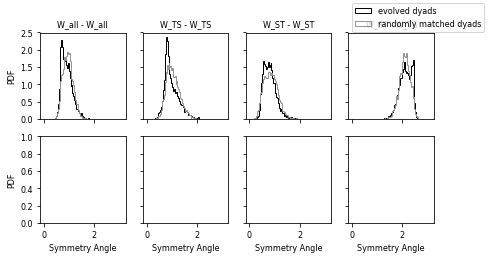

In [22]:
# Plot the distribution of each
# Make sure the clustering of data is done and the labels are in data_labels
# Define fonts
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

EVOLVED = cm.Greys(0.99)
RAND = cm.Greys(0.5)


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = SMALL_SIZE

# cmap = cm_clusters
n_row = 2; n_col = 4
#row1: evolved vs random
#row2: clusters of the evolved
fig, ax = plt.subplots(n_row,n_col, figsize=(7.0625, 3.5), sharex='col', sharey='row')

bins = np.arange(0, np.pi, 0.01*np.pi)
# chosen_clusters = range(n_clusters)


_ = ax[0,0].set_title('W_all - W_all')
l1 =ax[0,0].hist(symm_a1a2, bins=bins, color=EVOLVED, histtype='step', density=True, label='evolved dyads'); #ax[0,0].set_ylabel('')
l2 =ax[0,0].hist(symm_a1a2_n, bins=bins, color=RAND, histtype='step', density=True, label='randomly matched dyads'); 
# _=ax[1,0].hist(symm_a1a2sw0, bins=bins); ax[1,0].set_ylabel('a1sw10 - a2sw10')
_ = ax[0,1].set_title('W_TS - W_TS')
_ =ax[0,1].hist(symm_a1a2sw0, bins=bins, color=EVOLVED, histtype='step', density=True); #ax[0,0].set_ylabel('')
_ =ax[0,1].hist(symm_a1a2sw0_n, bins=bins, color=RAND, histtype='step', density=True); 
_ = ax[0,2].set_title('W_ST - W_ST')
_ =ax[0,2].hist(symm_a1a2sw1, bins=bins, color=EVOLVED, histtype='step', density=True); #ax[0,0].set_ylabel('')
_ =ax[0,2].hist(symm_a1a2sw1_n, bins=bins, color=RAND, histtype='step', density=True); 
_ = ax[0,3].set_title('W_ST - W_TS')
_ =ax[0,3].hist(symm_cross, bins=bins, color=EVOLVED, histtype='step', density=True); #ax[0,0].set_ylabel('')
_ =ax[0,3].hist(symm_cross_n, bins=bins, color=RAND, histtype='step', density=True); 


# for i,c in enumerate(chosen_clusters):
#     ax[1,0].hist(symm_a1a2[data_labels==c], bins=bins, color=cmap(c), alpha=0.8, histtype='step', density=True)
#     ax[1,1].hist(symm_a1a2sw0[data_labels==c], bins=bins, color=cmap(c), alpha=0.8, histtype='step', density=True)
#     ax[1,2].hist(symm_a1a2sw1[data_labels==c], bins=bins, color=cmap(c), alpha=0.8, histtype='step', density=True)
#     ax[1,3].hist(symm_cross[data_labels==c], bins=bins, color=cmap(c), alpha=0.8, histtype='step', density=True)

for j in range(n_col):
    ax[-1,j].set_xlabel('Symmetry Angle')
for i in range(n_row):
    ax[i,0].set_ylabel('PDF')
fig.legend()

# plt.savefig('Fig-symm.pdf', dpi=600)

In [73]:
# Test how much diversity there is in the high-symmetry dyads.
a1sw1_highsymm = a1sw1[symm_a1a2sw1<0.6]
a2sw1_highsymm = a2sw1[symm_a1a2sw1<0.6]
sw1_highsymm = np.concatenate((a1sw1_highsymm, a2sw1_highsymm), axis=0)

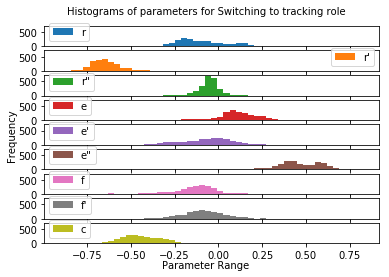

In [74]:
sw1highsymm_df = pd.DataFrame(sw1_highsymm, columns=ftr_names)
sw1highsymm_df.columns = pd.CategoricalIndex(ftr_names, ordered=True)


ax = sw1highsymm_df.plot.hist(bins=50, sharex=True, sharey=True, sort_columns=True, subplots=True)
for _,axi in np.ndenumerate(ax):
    axi.set_ylabel('')
fig=plt.gcf()
_ =fig.text(0.5, 0.04, 'Parameter Range', ha='center')
_ =fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
_ =fig.text(0.5,0.92, 'Histograms of parameters for Switching to tracking role', ha='center')

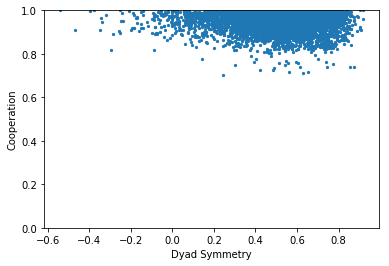

In [27]:
# Plot symmetry vs tracking error
# plt.scatter(symm_a0a1, hofloss[:,0], s=5)
plt.scatter(symm_a1a2, coop_a1a2, s=5)
plt.ylim(0,1)
plt.xlabel('Dyad Symmetry');
# plt.ylabel('Tracking Loss'); 
plt.ylabel('Cooperation'); # 

(0.46225399293498426, 1.0880899414655145, 0.017084811024792708, 0.01601183427544454, 0.03292340835271664)
Number of time steps where normal force is violated:  95


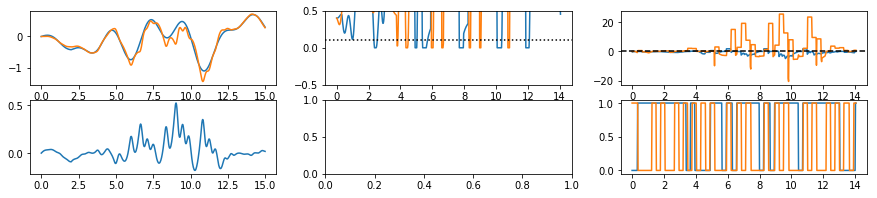

In [28]:
### Mix and match policies from different dyads

# Pick the 4 policies randomly
xa1sw1 = random.choice(sw1) #a1sw0[1,:]#random.choice(sw0)
xa1sw0 = a1sw0[1,:]#random.choice(sw1)
xa2sw1 = random.choice(sw1) #a2sw0[1,:]#random.choice(sw0)
xa2sw0 = a2sw0[1,:] #random.choice(sw1)

tmp_ind = ea_init_m_ones(list, n_params, n_floatparam, n_ctrlr_types)
i=1
sol = list(hoffparams[i])+ list(hofctrs[i])
tmp_ind = sol
tmp_agent = agents_bimodal_firing(tmp_ind)

tmp_agent.a1sw0 = xa1sw0;
tmp_agent.a1sw1 = xa1sw1;
tmp_agent.a2sw0 = xa2sw0;
tmp_agent.a2sw1 = xa2sw1;

# pid1 = ctrlr5
# pid2 = stblr1#[0., 0., 0., -0., 0., 0., -2, 0., 1.*2]
# tmp_agent.agent1w = [ctrlr4, stblr5]#[pid1, pid2]
tmp_agent.agent1w[0] = stblr5
tmp_agent.agent2w[0] = stblr1
# tmp_agent.agent2w = [ctrlr5, stblr1] #[pid1, pid2]
# tmp_agent.a1role =1
# tmp_agent.a2role =1


tt1, xf1, xf2, xrl1, xrl2, xev1, xev2, xpos, xref, ftr_vecs = simultest(tmp_agent, verbose=True) #simul(ctr, verbose=True)#
print(simultest(tmp_agent, verbose=False))
fig, ax = plt.subplots(2,3, figsize=(15,3))

t_win = int(len(tt1)/16); pltslc = slice(t_win*0,t_win*(-1))
#     ax[i].plot(time1, 5*xf1, label='5*force')
ax[0,0].plot(tt1, xref, label='ref')
ax[0,0].plot(tt1, xpos, label='pos')
ax[0,1].plot(tt1[pltslc], xf1[pltslc], label='force1')
ax[0,1].plot(tt1[pltslc], xf2[pltslc], label='force2')
ax[0,1].axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f- bounds')
ax[0,1].axhline(y=egg_bnd[1], ls=':', color='k')
ax[0,1].set_ylim((-0.5, 0.5))

ax[1,0].plot(tt1, xref-xpos, label='error')
ax[0,2].plot(tt1[pltslc], xev1[pltslc], label='Agent 1 Evidence')
ax[0,2].plot(tt1[pltslc], xev2[pltslc], label='Agent 2 Evidence')
ax[0,2].axhline(y=0, c='k', ls='--')
ax[1,2].plot(tt1[pltslc], xrl1[pltslc], label='Agent 1 role')
ax[1,2].plot(tt1[pltslc], xrl2[pltslc], label='Agent 2 role')

# for _,axij in np.ndenumerate(ax):
#         axij.legend(); axij.set_xlabel('Time')
        
print('Number of time steps where normal force is violated: ', 
      np.sum(np.minimum(xf1,xf2)<egg_bnd[0]) )#+
#       np.sum(np.minimum(xf1,xf2)>egg_bnd[1]))

In [23]:
# Make dataframes for specific parts of data
sw0_df = pd.DataFrame(sw0, columns=ftr_names)
sw0_df.columns = pd.CategoricalIndex(ftr_names, ordered=True)
sw1_df = pd.DataFrame(sw1, columns=ftr_names)
sw1_df.columns = pd.CategoricalIndex(ftr_names, ordered=True)

sw_df = pd.concat((sw0_df, sw1_df), axis='columns')

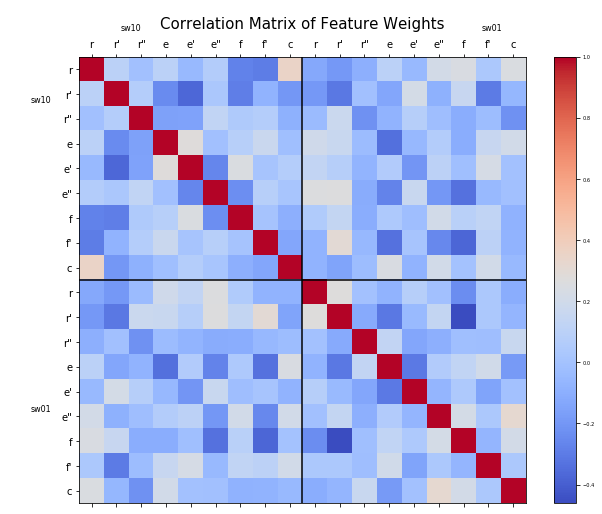

In [24]:
# sw0_corr = sw0_df.corr()
# plt.matshow(sw0_corr)
var_df = sw_df; var_name='sw'

fig = plt.figure(figsize=(10, 8))
plt.matshow(var_df.corr(), fignum=fig.number, cmap='coolwarm')
plt.xticks(range(var_df.shape[1]), var_df.columns, fontsize=10, rotation=0)
plt.yticks(range(var_df.shape[1]), var_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=5)
plt.title('Correlation Matrix of Feature Weights', fontsize=15);
plt.annotate('sw10', (0.2,0.94), xycoords='figure fraction')
plt.annotate('sw01', (0.8,0.94), xycoords='figure fraction')
plt.annotate('sw10', (0.05,0.8), xycoords='figure fraction')
plt.annotate('sw01', (0.05,0.2), xycoords='figure fraction')
plt.axhline(y=8.5, c='k'); plt.axvline(x=8.5, c='k')

### Distribution of parameters in the pareto front

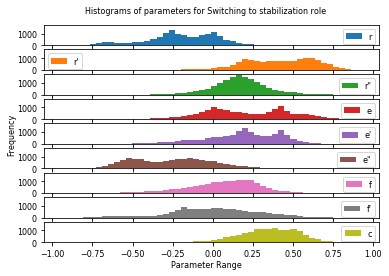

In [25]:
ax = sw0_df.plot.hist(bins=50, sharex=True, sharey=True, sort_columns=True, subplots=True)
for _,axi in np.ndenumerate(ax):
    axi.set_ylabel('')
fig=plt.gcf()
_ =fig.text(0.5, 0.04, 'Parameter Range', ha='center')
_ =fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
_ =fig.text(0.5,0.92, 'Histograms of parameters for Switching to stabilization role', ha='center')

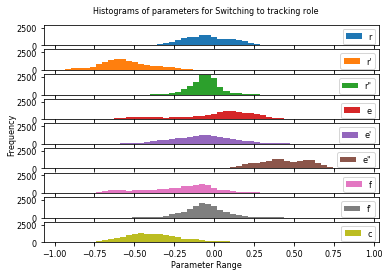

In [26]:
ax = sw1_df.plot.hist(bins=50, sharex=True, sharey=True, sort_columns=True, subplots=True)
for _,axi in np.ndenumerate(ax):
    axi.set_ylabel('')
fig=plt.gcf()
_ =fig.text(0.5, 0.04, 'Parameter Range', ha='center')
_ =fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
_ =fig.text(0.5,0.92, 'Histograms of parameters for Switching to tracking role', ha='center')

In [69]:
# hof_df = pd.DataFrame(hoffparams, columns=ftr_labels2)

In [70]:
# fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax = hof_df.plot.hist(by=['r0', 'e0'] ,bins=10)

### Check for symmetry of the evolved dyads

In [71]:
# Load Pareto Front data
pareto_filt = [1.5, 1*brkloss_coef] #[0.75, 2*brkloss_coef]#[0.85, 1.]
pareto_data =[]

 
for file_i in pareto_files:
    with open(file_i, 'rb') as data_file:
        pareto_data_i = pickle.load(data_file)
        paretos = [] #temp list for storing generations of 'good' individuals
        for gen_p in pareto_data_i:
            p_gen = [] #temp list for storing 'good' individuals
            for ind_objs in gen_p:
                if ind_objs[0] <pareto_filt[0] and ind_objs[1] <pareto_filt[1]:
                    p_gen.append(ind_objs)
            paretos.append(narr(p_gen))
#         paretos = [narr(gen_p) for gen_p in pareto_data_i] 
        pareto_data.append(paretos)

In [72]:
def calcCoopTracking(pareto_data):
    # generations x points x objectives
    trk_coop = []; #trk_err = [];
    for gen in pareto_data:
        if len(gen)==0:
            trk_coop.append(narr([np.inf, np.inf]))
            continue
        trk_err = gen[:,0]
        coopRatio = gen[:, 2]/gen[:, 3]
        coopRatio_ = np.minimum(coopRatio, coopRatio**-1)
        trk_coop.append(narr([trk_err, coopRatio_]))
    return trk_coop

In [73]:
plt.hist(pareto_data[2][-1][:,1])

IndexError: list index out of range

In [74]:
# selected_date = 'Oct182'
# pareto_path = 'data/'+selected_date+'/paretos'
# pareto_files = [join(pareto_path, f) for f in listdir(pareto_path) if isfile(join(pareto_path, f))]

IndexError: list index out of range

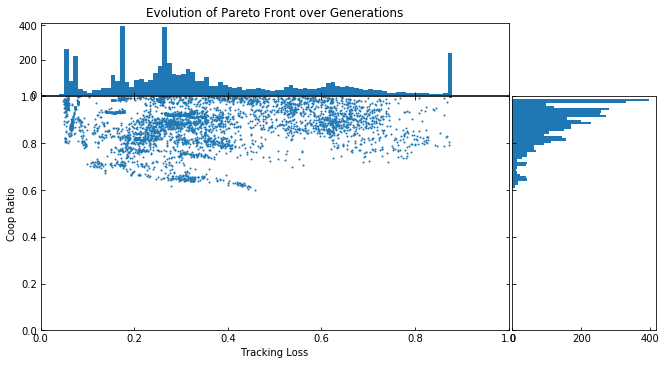

In [75]:
# plt_mode = '3d'
# for r in range(0, 3):
#     anim_path = 'data/'+selected_date+'/anims/'+str(r)+'.mp4'
# #     pareto_afname = 'anims/'+selected_date+'_run'+str(r)+'.mp4'
#     pareto_visualizer(pareto_data[r], anim_path, plt_mode, dsrate=300)

plt_mode = 'coop2d'
for r in range(0,2):
    anim_path = 'data/'+selected_date+'/anims/'+str(r)+'.mp4'
    plt_data = calcCoopTracking(pareto_data[r])
#     pareto_afname = 'anims/'+selected_date+'_run'+str(r)+'.mp4'
    pareto_visualizer(plt_data, anim_path, plt_mode, dsrate=300)

### Use TSNE to visualize the coefs

In [18]:
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans, DBSCAN, SpectralClustering

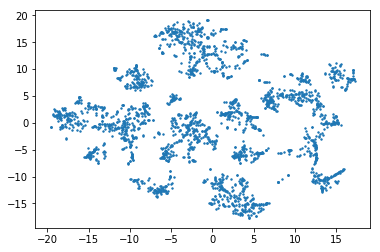

In [14]:
variable = popparams
pop_params_tsne = TSNE(n_components=2).fit_transform(variable)
plt.scatter(pop_params_tsne[:, 0], pop_params_tsne[:,1], s=2)

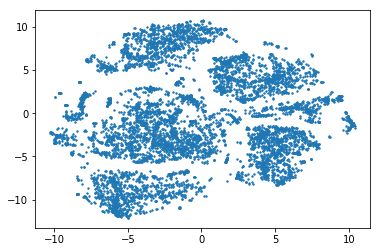

In [19]:
variable = hoffparams
hof_params_tsne = TSNE(n_components=2).fit_transform(variable)
plt.scatter(hof_params_tsne[:, 0], hof_params_tsne[:,1], s=2)

### Apply Clustering

In [59]:
variable = popparams



n_clusters = 8
KMpop1 = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=100, verbose=0, 
                         compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, 
                         init_size=None, n_init=3, reassignment_ratio=0.01)

KMpop1.fit(variable)
# print("Clustering Error (Bayesian information criterion) = ",\
#       '{:.2f}'.format(KMhof1.bic(hofparams_t)))
print("Clustering Score = ",\
      '{:.2f}'.format(KMpop1.score(variable)))
pop_labels = KMpop1.predict(variable)

Clustering Score =  -2682.40


In [179]:
variable = popparams #pop_params_tsne #



# n_clusters = 8
eps = 0.9
DBpop1 = DBSCAN(eps=eps, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=None)
# KMpop1 = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=100, verbose=0, 
#                          compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, 
#                          init_size=None, n_init=3, reassignment_ratio=0.01)

DBpop1.fit(variable)
# print("Clustering Error (Bayesian information criterion) = ",\
#       '{:.2f}'.format(KMhof1.bic(hofparams_t)))
# print("Clustering Score = ",\
#       '{:.2f}'.format(DBpop1.score(variable)))
pop_labels2 = DBpop1.fit_predict(variable)

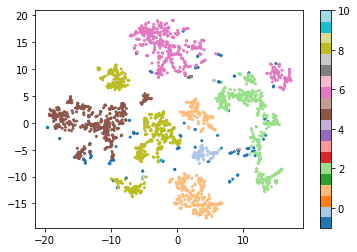

In [180]:
plt.scatter(pop_params_tsne[:, 0], pop_params_tsne[:,1], s=4, c=pop_labels2, cmap=plt.cm.get_cmap('tab20'))
plt.colorbar()

# fig, ax = plt.subplots(int(np.ceil(n_clusters/2)),2, figsize=(12,15), sharey=True)
# xtt = np.arange(n_w)
# for i in range(n_clusters):
#     c_axis = ax[i//2, i%2]
#     c_axis.stem(KMpop1.cluster_centers_[i])
#     c_axis.set_xticks(xtt); c_axis.set_xticklabels(ftr_names)
#     c_axis.set_ylabel(str(i))
# ax[0,0].set_title('Cluster Centroids')

Text(0.5, 1.0, 'Relationship between Task performance and Secondary metrics \n(data from last generation)')

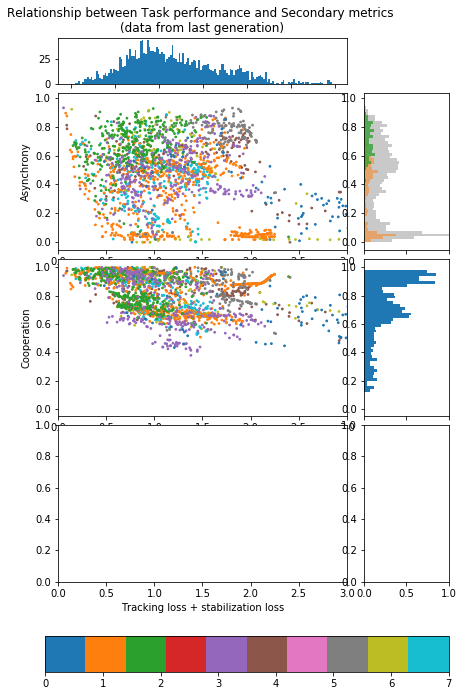

In [135]:
# ax=np.zeros(3)#, dtype=matplotlib.axes._subplots.AxesSubplot)
data = popobj; data_labels = pop_labels
cmap=cm.get_cmap('tab10')#('Pastel1')

fig = plt.figure(figsize=(7, 10))
grid = plt.GridSpec(10, 4, hspace=0.2, wspace=0.2)

xbins = np.arange(0,3, 0.02)
ybins = np.arange(0,1, 0.02)
ybins_symm = np.arange(-1,1, 0.04)

# ax_xhist = fig.add_subplot(grid[rows_above:rows_above+1, :-1], xticklabels=[], yticklabels=[], sharex=axi)

for i in range(3):
    rows_above=i*3
    axi = fig.add_subplot(grid[rows_above+1:rows_above+4, :-1])
    axi_yhist = fig.add_subplot(grid[rows_above+1:rows_above+4, -1], sharey=axi)

ax = fig.get_axes(); ax = narr(ax).reshape(-1,2)

ax[0,0].set_ylabel('Asynchrony')
l1= ax[0,0].scatter(data[:,0]+data[:,1], data[:,5],s=3, c=data_labels, cmap=cmap)
ax[0,1].hist(data[:,5], bins=ybins, orientation='horizontal', color=cm.Greys(0.5), alpha=0.5)
ax[0,1].hist(data[data_labels==1,5], bins=ybins, orientation='horizontal', color=cmap(1), alpha=0.5)
ax[0,1].hist(data[data_labels==2,5], bins=ybins, orientation='horizontal', color=cmap(2), alpha=0.5)
ax[0,1].hist(data[data_labels==2,5], bins=ybins, orientation='horizontal', color=cmap(2), alpha=0.5)
ax[0,1].set_xlim(0,200)
ax[0,1].set_xticklabels([])

ax[1,0].set_ylabel('Cooperation')
ax[1,0].scatter(data[:,0]+data[:,1], data[:,-1],s=3, c=data_labels, cmap=cmap)
ax[1,1].hist(data[:,-1], bins=ybins, orientation='horizontal')
ax[1,1].set_xlim(0,200)
ax[1,1].set_xticklabels([])

# ax[2,0].set_ylabel('Symmetry')
# ax[2,0].scatter(data[:,0]+data[:,1], data[:,6],s=3, c=data_labels, cmap=cmap)
# ax[2,1].hist(data[:,6], bins=ybins_symm, orientation='horizontal')
# ax[2,1].set_xlim(0,200)


ax[-1,0].set_xlabel('Tracking loss + stabilization loss')

ax[0,0].set_xlim(0,3)
ax[1,0].set_xlim(0,3)
ax[2,0].set_xlim(0,3)
# plt.colorbar()
cax = fig.add_axes([0.1, 0., 0.8, 0.05])
fig.colorbar(l1, cax=cax, orientation='horizontal')

#Add x hist
ax_xhist = fig.add_subplot(grid[0, :-1], xticklabels=[])
_ = ax_xhist.hist(data[:,0]+data[:,1], bins=xbins)

ax_xhist.set_title('Relationship between Task performance and Secondary metrics \n(data from last generation)')

In [25]:
variable = hoffparams

n_clusters = 5
KMhof1 = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=100, verbose=0, 
                         compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, 
                         init_size=None, n_init=3, reassignment_ratio=0.01)

KMhof1.fit(variable)
# print("Clustering Error (Bayesian information criterion) = ",\
#       '{:.2f}'.format(KMhof1.bic(hofparams_t)))
print("Clustering Score = ",\
      '{:.2f}'.format(KMhof1.score(variable)))
hof_labels = KMhof1.predict(variable)

Clustering Score =  -6295.98


In [26]:
cmap_ = cm.get_cmap('tab10')
cmap_ = cmap_(np.linspace(0,n_clusters/10, n_clusters))
cm_clusters = LinearSegmentedColormap.from_list('tab10clusters', cmap_, N=n_clusters)


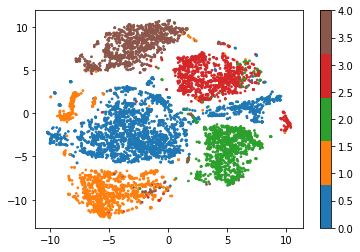

In [27]:
plt.scatter(hof_params_tsne[:, 0], hof_params_tsne[:,1], s=3, c=hof_labels, cmap=cm_clusters)
plt.colorbar()

# fig, ax = plt.subplots(int(np.ceil(n_clusters/2)),2, figsize=(12,15), sharey=True)
# xtt = np.arange(n_w)
# for i in range(n_clusters):
#     c_axis = ax[i//2, i%2]
#     c_axis.stem(KMhof1.cluster_centers_[i])
#     c_axis.set_xticks(xtt); c_axis.set_xticklabels(ftr_names)
#     c_axis.set_ylabel(str(i))
# ax[0,0].set_title('Cluster Centroids')
# plt.savefig('hof_cluster.pdf', dpi=600)

In [29]:
# np.save('data/'+selected_date+'/hof_labels', hof_labels)

In [30]:
data = hofobj; data_labels = hof_labels
chosen_clusters = [4, 3, 2, 1, 0]

trk_data = data[:,0]; stbl_data = data[:,1];
max_data = np.maximum(trk_data, stbl_data)
async_data = data[:,5]; coop_data = data[:,-1]

xlim = 1.
xbins = np.arange(0,xlim, 0.05)
ybins = np.arange(0,1, 0.04)

In [1]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = SMALL_SIZE

pt_size = 0.25
#         makes it so the text labels save as text and not an image of text)
# ax[0].tick_params(bottom=False, labelbottom=False)
#         turns off ticks and tick labels on sides of figures where you don't need them

cmap=cm_clusters

fig = plt.figure(figsize=(7.0625, 5))
n_row=2; n_col=3
row_gwidth = 3; col_gwidth = 3;
# grid = plt.GridSpec(10, 4, hspace=0.2, wspace=0.2)
grid = plt.GridSpec(n_row*row_gwidth+1, n_col*col_gwidth+1, figure=fig)


# ybins_symm = np.arange(-1,1, 0.04)

# ax_xhist = fig.add_subplot(grid[rows_above:rows_above+1, :-1], xticklabels=[], yticklabels=[], sharex=axi)

for i in range(n_row):
    g_rows_above=i*row_gwidth
    ax1 = fig.add_subplot(grid[g_rows_above+1:g_rows_above+4, 0:col_gwidth])
    ax2 = fig.add_subplot(grid[g_rows_above+1:g_rows_above+4, col_gwidth:2*col_gwidth])
    ax3 = fig.add_subplot(grid[g_rows_above+1:g_rows_above+4, 2*col_gwidth:3*col_gwidth])
    axi_yhist = fig.add_subplot(grid[g_rows_above+1:g_rows_above+4, -1], sharey=ax1)

ax = fig.get_axes(); ax = narr(ax).reshape(n_row, n_col+1)

ax[0,0].set_ylabel('Anti-synchrony')
l1= ax[0,0].scatter(trk_data, async_data,s=pt_size, alpha=0.5, c=data_labels, cmap=cmap)
ax[0,1].scatter(stbl_data, async_data,s=pt_size, alpha=0.5, c=data_labels, cmap=cmap)
ax[0,2].scatter(np.maximum(trk_data,stbl_data), async_data,s=pt_size, alpha=0.5, c=data_labels, cmap=cmap)

ax[0,-1].hist(async_data, bins=ybins, orientation='horizontal', color='k', histtype='step', density=True)
for i,c in enumerate(chosen_clusters):
    ax[0,-1].hist(async_data[data_labels==c], bins=ybins, orientation='horizontal', color=cmap(c), alpha=0.5, histtype='step', density=True)
    
ax[0,-1].tick_params(bottom=False, labelbottom=False, left=False, labelleft = False)

ax[1,0].set_ylabel('Load-sharing')
ax[1,0].scatter(trk_data, coop_data,s=pt_size, alpha=0.5, c=data_labels, cmap=cmap)
ax[1,1].scatter(stbl_data, coop_data,s=pt_size, alpha=0.5, c=data_labels, cmap=cmap)
ax[1,2].scatter(np.maximum(trk_data,stbl_data), coop_data, s=pt_size, alpha=0.5, c=data_labels, cmap=cmap)

ax[1,-1].hist(coop_data, bins=ybins, orientation='horizontal', color='k', histtype='step', density=True)
for i,c in enumerate(chosen_clusters):
    ax[1,-1].hist(coop_data[data_labels==c], bins=ybins, orientation='horizontal', color=cmap(c), alpha=0.5, histtype='step', density=True)
# ax[1,-1].set_xlim(0,400)
ax[-1,-1].tick_params(left=False, labelleft = False)

ax[-1,0].set_xlabel('Tracking loss')
ax[-1,1].set_xlabel('Stabilization loss')
ax[-1,2].set_xlabel('Max (T. loss, S. loss)')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlim(0,xlim)
        
# for i in range(n_row-1):
for j in range(n_col-1):
    ax[0,j].tick_params(bottom=False, labelbottom=False)

for i in range(n_row):
    for j in range(1, n_col):
        ax[i,j].tick_params(left=False, labelleft = False)

# ax[2,0].set_xlim(0,3)
# plt.colorbar()
# cax = fig.add_axes([0.1, 0., 0.8, 0.05])
# fig.colorbar(l1, cax=cax, orientation='horizontal')

#Add x hist
ax0_xhist = fig.add_subplot(grid[0, 0:3], xticklabels=[])
ax1_xhist = fig.add_subplot(grid[0, 3:6], xticklabels=[], sharey=ax0_xhist)
ax2_xhist = fig.add_subplot(grid[0, 6:9], xticklabels=[], sharey=ax0_xhist)
ax1_xhist.tick_params(left=False, labelleft = False)
ax2_xhist.tick_params(left=False, labelleft = False)

# _ = ax0_xhist.hist(trk_data, bins=xbins, color=cm.Greys(0.5), alpha=0.5)

ax0_xhist.hist(trk_data, bins=xbins, color='k', histtype='step', density=True)
for i,c in enumerate(chosen_clusters):
    ax0_xhist.hist(trk_data[data_labels==c], bins=xbins, color=cmap(c), alpha=0.5, histtype='step', density=True)

ax1_xhist.hist(stbl_data, bins=xbins, color='k', histtype='step', density=True)
for i,c in enumerate(chosen_clusters):
    ax1_xhist.hist(stbl_data[data_labels==c], bins=xbins, color=cmap(c), alpha=0.5, histtype='step', density=True)
    
ax2_xhist.hist(max_data, bins=xbins, color='k', histtype='step', density=True)
for i,c in enumerate(chosen_clusters):
    ax2_xhist.hist(max_data[data_labels==c], bins=xbins, color=cmap(c), alpha=0.5, histtype='step', density=True)

ax0_xhist.set_ylabel('PDF')
ax1_xhist.set_title('Relationship between Task performance and Secondary metrics \n(data from pareto front)')
# plt.savefig('async-coop.pdf', dpi=600)


NameError: name 'mpl' is not defined

Text(0, 0.5, 'Load-sharing')

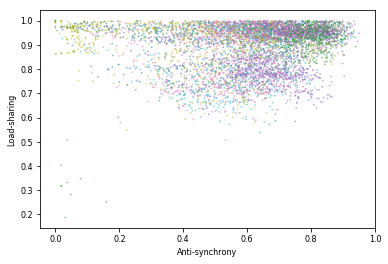

In [260]:
plt.scatter(data[:,5],data[:,-1], s=0.5, alpha=0.5, c=data_labels, cmap=cmap)
plt.xlabel('Anti-synchrony')
plt.ylabel('Load-sharing')
# l1= ax[0,0].scatter(data[:,0]+data[:,1], data[:,5],s=0.5, alpha=0.5, c=data_labels, cmap=cmap)

<a id='other_analyses'></a>
## Other analyses

<a id='see_trajs'></a>
### Visualize the Trajectories

Loss=  (0.5346661837283962, 0.20760346645809044, 0.008203866025495369, 0.007787713278325999, 0.000967201314244209)
Loss=  (0.6561148385699823, 0.24085065265046396, 0.007370903469293494, 0.007086118462152112, 0.0009851463988025297)
Loss=  (0.11306298386466668, 0.1336219712008374, 0.011998460607660159, 0.012194504132342032, 0.0019177532282217565)
Loss=  (0.4999416183976375, 0.19978234663358593, 0.00814980669233149, 0.008104690210586983, 0.0010916204423360228)
Loss=  (0.1310322464340258, 0.23382693821007852, 0.012307965284413218, 0.013630952480025292, 0.013075384136396018)
Loss=  (0.06497964801555196, 0.32268384727593785, 0.01165840313657764, 0.010515023917623378, 0.0013055456280767802)
Loss=  (0.43097503034351514, 0.17752492489177865, 0.008618790228251946, 0.008422729909026053, 0.0010522315594238825)
Loss=  (0.9882424625867168, 0.0, 0.004000000000000001, 0.004000000000000001, 0.0001709515859766277)
Loss=  (0.10382976915550826, 0.08333082563088075, 0.012278774423271133, 0.0121011225113781

Text(0.5, 0, 'Time')

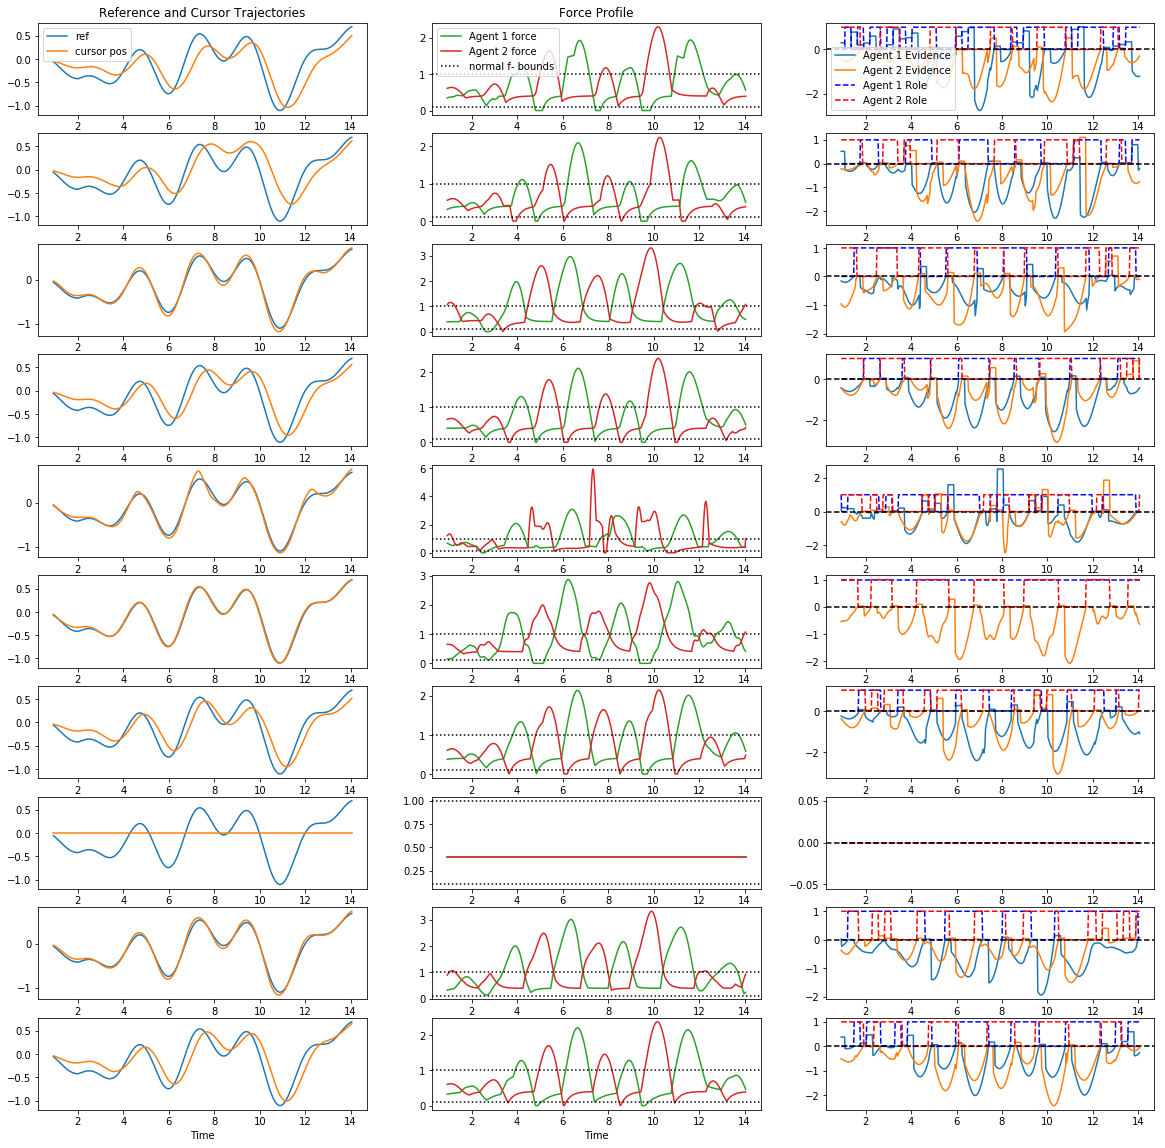

In [38]:
# Select 10 random solutions from the top cluster
np.set_printoptions(precision=3)
solutions = copy.deepcopy(hoffparams)
plt_sol = np.random.randint(solutions.shape[0], size=10)

# plt_sol = solutions[8:10,:]
n_sol = len(plt_sol)
xtt = np.arange(n_floatparam)
fig, ax = plt.subplots(n_sol, 3, figsize=(20,2*n_sol))
# for ax_ind, axij in np.ndenumerate(ax):
#     if ax_ind[1]==2:
#         axij.set_xlim([0, n_floatparam])

for i in range(n_sol):   
#     sol = solutions[plt_sol[i]]
    sol = list(hoffparams[plt_sol[i]])+ list(hofctrs[plt_sol[i]])
#     print('solution ',i, ' = ', sol)
    tt1, xf1, xf2, xrl1, xrl2, xev1, xev2, xpos, xref, ftr_vecs = simultest(sol, verbose=True)
    print('Loss= ', simultest(sol, verbose=False))
#     time2, f1, f2, role1, role2, pos, simtraj[0,:], ftr_vecs
#     tt1, xf1, xf2, xpos, xref = simul(plt_sol[i], verbose=True)

    t_win = int(len(tt1)/16); pltslc = slice(t_win*1,t_win*(-1))
#     ax[i].plot(time1, 5*xf1, label='5*force')
    ax[i,0].plot(tt1[pltslc], xref[pltslc], label='ref', c=cm.tab10(0))
    ax[i,0].plot(tt1[pltslc], xpos[pltslc], label='cursor pos', c=cm.tab10(1))
    ax[i,1].plot(tt1[pltslc], xf1[pltslc], c=cm.tab10(2), label='Agent 1 force')
    ax[i,1].plot(tt1[pltslc], xf2[pltslc], c=cm.tab10(3), label='Agent 2 force')
    
#     ax[i,2].stem(xtt, sol[:n_floatparam])
    ax[i,2].plot(tt1[pltslc], xev1[pltslc], label='Agent 1 Evidence')
    ax[i,2].plot(tt1[pltslc], xev2[pltslc], label='Agent 2 Evidence')
    vis_scale = 1 #max(np.maximum(xev1, xev2))
    ax[i,2].plot(tt1[pltslc], vis_scale*xrl1[pltslc], '--b', label='Agent 1 Role')
    ax[i,2].plot(tt1[pltslc], vis_scale*xrl2[pltslc], '--r', label='Agent 2 Role')
    ax[i,2].axhline(y=0, c='k', ls='--')
#     for k in range(n_floatparam):
#         if k%n_w <3:
#             ax[i,2].scatter(xtt[k], sol[k], c=cm.tab10(0))
#         else:
#             ax[i,2].scatter(xtt[k], sol[k], c=cm.tab10(1))
    
    ax[i,1].axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f- bounds')
    ax[i,1].axhline(y=egg_bnd[1], ls=':', color='k')

    
    #/////
    
#     ax[i,2].set_ylim(-0.5, 0.5)
#     # Adding the necessary labels to the plot
#     for pt in range(len(ftr_labels)):
#         if pt%n_w==0:
#             ax[i,2].axvline(x=pt, ls=':', c='red')
#     ax[i,2].set_xticks(xtt); ax[i,2].set_xticklabels(ftr_labels)
#     ax[i,2].axvspan(0, 2*n_w, facecolor=cm.Pastel1(2))
#     ax[i,2].axvspan(2*n_w, 4*n_w, facecolor=cm.Pastel1(0))
    
    
#     for k, lbl in enumerate(ctr_labels):
#         ax[i,2].annotate(lbl, (k/len(ctr_labels), 9/10), xycoords='axes fraction')

# for _,axij in np.ndenumerate(ax):
#         axij.legend(); 
ax[0,0].legend();ax[0,1].legend(); ax[0,2].legend();

ax[0,0].set_title('Reference and Cursor Trajectories')
ax[0,1].set_title('Force Profile')
# ax[0,2].set_title('Coefficients')
ax[-1,0].set_xlabel("Time")
ax[-1,1].set_xlabel("Time")
# ax[-1,2].set_xlabel("Features")


In [68]:
print('Number of time steps where normal force is violated: ', 
      np.sum(np.minimum(xf1,xf2)<egg_bnd[0]) +
      np.sum(np.minimum(xf1,xf2)>egg_bnd[1]))

Number of time steps where normal force is violated:  67


In [69]:
i=-1
sol = list(hoffparams[plt_sol[i]])+ list(hofctrs[plt_sol[i]])
# sol = list(hoffparams[i])+ list(hofctrs[i])
simultest(sol, verbose=False)

(0.5946315460488932,
 0.06956669333283909,
 0.32772843387496375,
 0.31069346465012887,
 0.16424565644076003)

In [240]:
att = narr([False,True,False,True])
btt = np.where(att)
# type(btt[0])
att[btt]

array([ True,  True])

In [20]:
# Get the role spans for figure 1
def get_swSpans(xrole):
    
    spans = []
    role_dif = np.diff(xrole, prepend=1)
    endpts = np.where(role_dif!=0)
    endpts = endpts[0]
#     print(endpts)
    for i in range(1,len(endpts)): 
        pt1 = endpts[i-1]; pt2 = endpts[i]
        spans.append([int((pt1+pt2)/2), pt2-pt1, xrole[pt2-1]])

    return spans

In [41]:
# xrl1
xrl1_spans = get_swSpans(xrl1); xrl2_spans = get_swSpans(xrl2)
print(xrl1_spans)

[[16, 11, 0.0], [27, 11, 1.0], [52, 38, 0.0], [87, 32, 1.0], [127, 48, 0.0], [174, 46, 1.0], [221, 48, 0.0], [270, 51, 1.0], [319, 47, 0.0], [366, 46, 1.0], [418, 58, 0.0], [471, 48, 1.0], [511, 32, 0.0], [532, 11, 1.0], [543, 11, 0.0], [558, 18, 1.0], [572, 11, 0.0], [583, 11, 1.0]]


In [65]:
# np.argmin(hofloss[:,0])
hofloss[4647]

array([0.052, 0.326, 0.011, 0.012, 0.002])

### Apply PCA to the params
We imagine that certain features might get grouped together to form single components.

In [26]:
variable = sw1

from sklearn.decomposition import PCA

n_components=0.9
PCA_data = PCA(n_components=n_components, svd_solver = 'full')
PCA_data.fit(variable)
print('Data points of shape ', variable.shape, ' decomposed into ', PCA_data.n_components_, ' components.')
print("Decomposition Score (average log-likelihood of all samples) = ",\
      '{:.2f}'.format(PCA_data.score(variable)))
# Project the dat into the new components
hofparams_cmp = PCA_data.transform(variable)
print('hofparams_cmp.shape = ', hofparams_cmp.shape)

Data points of shape  (26, 9)  decomposed into  5  components.
Decomposition Score (average log-likelihood of all samples) =  2.39
hofparams_cmp.shape =  (26, 5)


explained_variance_ratio:  [0.39 0.23 0.14 0.08 0.07]


Text(0.5, 1.0, 'Building Components of the Evolved Agent Params')

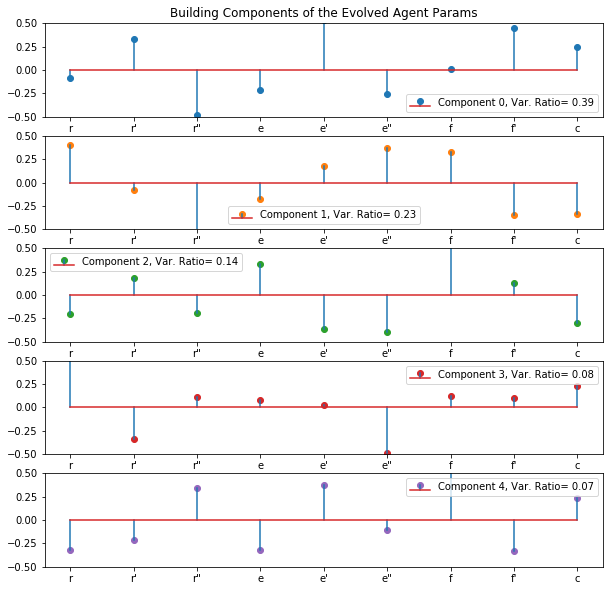

In [27]:
np.set_printoptions(precision=2)
print('explained_variance_ratio: ', PCA_data.explained_variance_ratio_)
cmap = plt.get_cmap("tab10")
n_plt=min(5,PCA_data.n_components_) 
fig, ax = plt.subplots(n_plt, figsize=(10,n_plt*2))
xtt= np.arange(len(ftr_names))
for i in range(n_plt):
    axi = ax[i]
    axi.stem(PCA_data.components_[i], markerfmt='C'+str(i)+'o', label='Component '+str(i)
               +', Var. Ratio= '+'{:.2f}'.format(PCA_data.explained_variance_ratio_[i]))
    axi.legend()
    axi.set_xticks(xtt); axi.set_xticklabels(ftr_names)
    axi.set_ylim(-0.5, 0.5)
    
#     # Adding the necessary labels to the plot
#     for pt in range(len(ftr_names)):
#         ax.axvline(x=pt, ls=':', c='gray')
#         if pt%n_w==0:
#             ax.axvline(x=pt, ls=':', c='red')
#     ax.set_xticks(xtt); ax.set_xticklabels(ftr_labels)

#     for k, lbl in enumerate(ctr_labels):
#         ax.annotate(lbl, (k/len(ctr_labels), 9/10), xycoords='axes fraction')
ax[0].set_title('Building Components of the Evolved Agent Params')



### Cluster the solutions

In [47]:
from sklearn.mixture import GaussianMixture


def plot_cluster_hofloss(hofloss, hof_labels, n_components, mode='lin'):
    
    ax = Axes3D(plt.gcf())
    mode_suf = mode if mode!='lin' else ''
    xlbl='X: Tracking Loss '+mode_suf
    ylbl='Y: Energy Loss '+mode_suf
    zlbl='Z: Normal Force Loss '+mode_suf
    
    for i in range(n_components):
        ax.scatter(hofloss[hof_labels == i, 0], 
                   hofloss[hof_labels == i, 2], 
                   hofloss[hof_labels == i, 1], c=narr([cm.tab20(i)]), label='C'+str(i))
        
    ax.set_xlim((0.01,1))
    ax.set_ylim((0, 5))
    ax.set_zlim((0.001, 0.5))

    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.set_zlabel(zlbl)
    ax.legend()
    
    ax.set_title('Loss Clusters')


#### Cluster the projected data

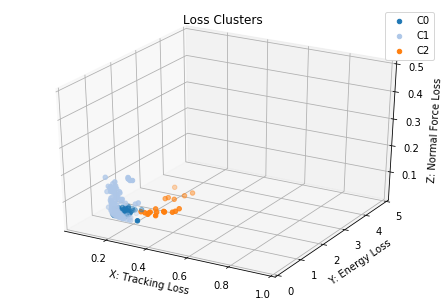

In [77]:
# Only keep the top components
# hofparams_cmp_red = hofparams_cmp[:,:10] 

n_clusters = 3
KMhofcmp = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=100, verbose=0, 
                         compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, 
                         init_size=None, n_init=3, reassignment_ratio=0.01)
# GMhofcmp = GaussianMixture(n_clusters, covariance_type='full', tol=0.001, 
#                            reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', 
#                            weights_init=None, means_init=None, precisions_init=None, 
#                            random_state=None, warm_start=False, verbose=0, verbose_interval=10)

KMhofcmp.fit(hofparams_cmp)
# print("Clustering Error (Bayesian information criterion) = ",\
#       '{:.2f}'.format(KMhof1.bic(hofparams_t)))
hof_labels = KMhofcmp.predict(hofparams_cmp)

plot_cluster_hofloss(hofloss, hof_labels, n_clusters, mode='lin')


In [78]:
i_cl = 1; #n_components=0.9; 
cl = hofparams_cmp[hof_labels==i_cl]
PCA_cl = PCA(n_components='mle', svd_solver = 'full')
PCA_cl.fit(cl)
print('Cluster ', i_cl, ', containing ', len(cl),' solutions decomposed into ', PCA_cl.n_components_, ' components.')
print("Decomposition Score (average log-likelihood of all samples) = ",\
      '{:.2f}'.format(PCA_cl.score(cl)))

Cluster  1 , containing  168  solutions decomposed into  8  components.
Decomposition Score (average log-likelihood of all samples) =  19.06


explained_variance_ratio:  [0.33 0.29 0.12 0.08 0.07 0.04 0.03 0.02]


Text(0.5, 1.0, 'Building Components of the Projected Params')

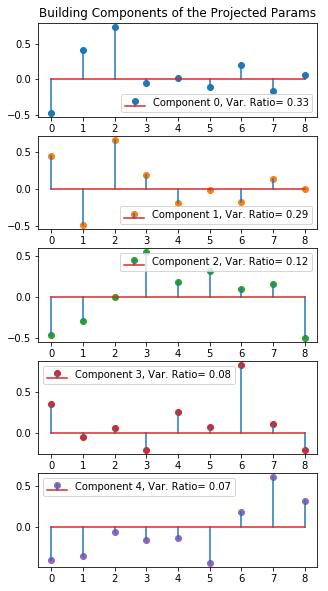

In [79]:

print('explained_variance_ratio: ', PCA_cl.explained_variance_ratio_)
cmap = plt.get_cmap("tab10")
n_plt= min(5, PCA_cl.n_components_)
fig, ax = plt.subplots(n_plt, figsize=(5,n_plt*2))
for i in range(n_plt):
    ax[i].stem(PCA_cl.components_[i], markerfmt='C'+str(i)+'o', label='Component '+str(i)
               +', Var. Ratio= '+'{:.2f}'.format(PCA_cl.explained_variance_ratio_[i]))
    ax[i].legend()
ax[0].set_title('Building Components of the Projected Params')



#### Transform the coefs back to original domain to get denoised top solutions

In [ ]:
hofparams_cmp_cmp2 = PCA_cl.transform(cl)
hofparams_cmp_cmp2_red = hofparams_cmp_cmp2; hofparams_cmp_cmp2_red[:, 5:]=0
hofparams_cmp_red = PCA_cl.inverse_transform(hofparams_cmp_cmp2_red)
solutions_red = PCA_data.inverse_transform(hofparams_cmp_red)
solutions_red.shape

#### Clustering based on params only

### Visualize the coefs for a single cluster

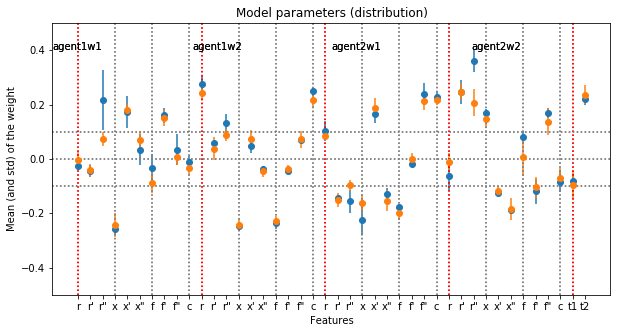

In [58]:
i_cl1 = 0
i_cl2 = 2
coeffs1 = narr(hofparams_t[hof_labels==i_cl1]).reshape((-1,n_params))
coeffs2 = narr(hofparams_t[hof_labels==i_cl2]).reshape((-1,n_params))
fig, ax = plt.subplots(1,1, figsize=(10,5))
viz_coefs(ax, coeffs1, split_points=split_points, n_w=n_w, ctr_labels=ctr_labels, ftr_labels=ftr_labels)
viz_coefs(ax, coeffs2, split_points=split_points, n_w=n_w, ctr_labels=ctr_labels, ftr_labels=ftr_labels)

### Analyze a single chosen solution

In [26]:
ch_sol = plt_sol[0]

In [27]:
ch_sol

array([0.515, 0.556, 0.667, 0.398, 0.546, 0.524, 0.365, 0.622, 0.393,
       0.558, 0.657, 0.57 , 0.634, 0.327, 0.555, 0.363, 0.364, 0.508,
       0.497, 0.558, 0.519, 0.436, 0.45 , 0.45 , 0.578, 0.391, 0.283,
       0.505, 0.497, 0.583, 0.602, 0.576, 0.697, 0.588, 0.413, 0.383,
       0.43 , 0.452, 0.575, 0.32 , 0.308, 0.719])

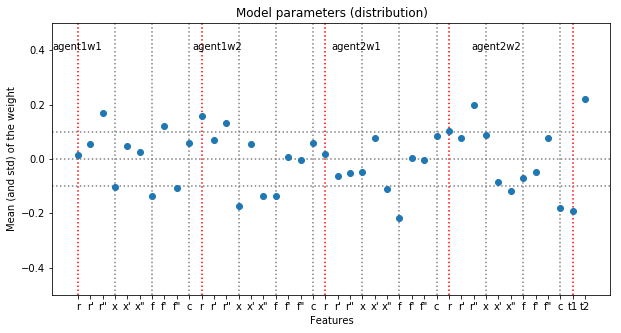

In [28]:
# Plot the coefs
ch_sol_arr = narr([translate(ch_sol),])
fig, ax = plt.subplots(1,1,figsize=(10,5))
viz_coefs(ax, ch_sol_arr, split_points=split_points, n_w=n_w, ctr_labels=ctr_labels, ftr_labels=ftr_labels)

In [29]:
# ch_sol = narr([0.47, 0.54, 0.56, 0.28, 0.5 , 0.51, 0.41, 0.49, 0.44, 0.52, 0.66,
#                0.48, 0.64, 0.35, 0.57, 0.36, 0.34, 0.56, 0.51, 0.56, 0.58, 0.41,
#                0.47, 0.4 , 0.63, 0.46, 0.3 , 0.51, 0.5 , 0.59, 0.63, 0.56, 0.61,
#                0.74, 0.5 , 0.26, 0.33, 0.51, 0.56, 0.28, 0.27, 0.68])


In [30]:
xa1 = agents_l_2mod(ch_sol)
print('agent1th=', xa1.agent1th)
print('agent1w1=', xa1.agent1w1)
print('agent1w2=',xa1.agent1w2)

print('agent2th=', xa1.agent2th)
print('agent2w1=', xa1.agent2w1)
print('agent2w2=', xa1.agent2w2)


agent1th= [-0.866]
agent1w1= [ 0.031  0.112  0.334 -0.203  0.092  0.049 -0.27   0.244 -0.214  0.115]
agent1w2= [ 0.313  0.14   0.268 -0.346  0.11  -0.273 -0.273  0.016 -0.006  0.115]
agent2th= [0.985]
agent2w1= [ 0.038 -0.128 -0.101 -0.1    0.156 -0.218 -0.435  0.009 -0.006  0.165]
agent2w2= [ 0.204  0.152  0.394  0.175 -0.173 -0.234 -0.14  -0.097  0.151 -0.36 ]


In [31]:
# tmp_sol = hofparams[100,:]
# tt1, xf1, xf2, xpos, xref = simul(tmp_sol, verbose=True)

# fig = plt.figure(figsize=(10,8))
# gs = gridspec.GridSpec(2, 1,
#                        height_ratios=[1, 3], figure=fig)#@@
# ax0 = plt.subplot(gs[0])

# ax0.plot(tt1, xref, label='reference')
# ax0.plot(tt1, xpos, label='position')
# ax0.plot(tt1, xf1, label='f1')
# ax0.plot(tt1, xf2, label='f2')
# ax0.legend()
# simul(tmp_sol, verbose=False)#simultest(ch_sol, 50, verbose=True)

#### Plot signals to see correlations

In [32]:
print('training loss = ', simul(ch_sol, verbose=False))
print('testing loss = ', simultest(ch_sol, 15, verbose=False))
tt1, xf1, xf2, xpos, xref, ftr_vecs = simultest(ch_sol, 20, verbose=True)
ftr_vecs = narr(ftr_vecs)

training loss =  (0.2816533935656673, 0.026076557705394045, 0.8961444416112533, 0.1105061540015524)
testing loss =  (0.2577203698014015, 0.013121572104508303, 0.909417809186355, 0.21954738626007428)


In [33]:
# fig, ax = plt.subplots()

# t_win = int(len(tt1)/1)
# pltslc = slice(t_win*0,-1)
    

# xacc = np.diff(xpos, n=2, prepend=[0,0])/tstep

# ax.plot(tt1[pltslc], xref[pltslc])
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Position (m)')
# ax.set_title('Test Reference Trajectory')

In [34]:
tmp_df1 = np.diff(xf1, prepend=0); tmp_df2 = np.diff(xf2, prepend=0);
tmp_err = ftr_vecs[:,0]-ftr_vecs[:,3]
tmp_errdd = np.diff(tmp_err, n=2, prepend=[0,0])/(tstep**2)
tmp_swtch1 = traj_max_amp*(tmp_err>param2th(ch_sol[-2]))#.astype('float')
tmp_swtch2 = 2*traj_max_amp*(-tmp_err>param2th(ch_sol[-1]))#.astype('float')
tmp_minf = ftr_vecs[:,6]; tmp_ref = ftr_vecs[:,0]

Text(0.5, 0, 'Time (s)')

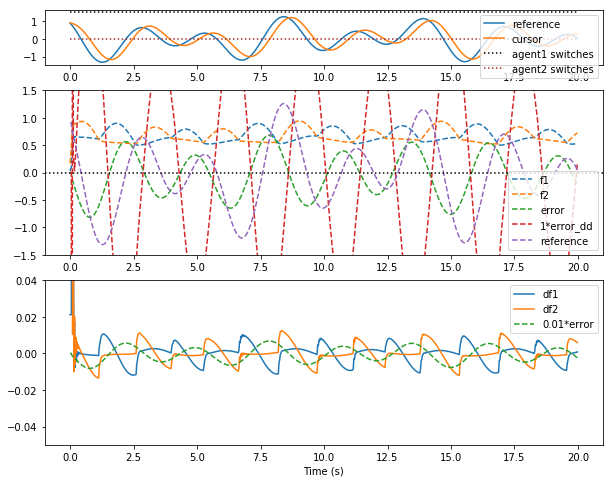

In [35]:
# Plot 
# fig, ax = plt.subplots(2,1, figsize=(10,8))

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1,
                       height_ratios=[1, 3,3], figure=fig)#@@
ax0 = plt.subplot(gs[0])

ax0.plot(tt1, xref, label='reference')
ax0.plot(tt1, xpos, label='cursor')

ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# ax1.plot(tt1, tmp_df1, 'indigo', label='df1'); 
ax2.plot(tt1, tmp_df1, label='df1'); 
ax2.plot(tt1, tmp_df2, label='df2')
# ax1.plot(tt1, 1*(tmp_df1-tmp_df2), 'darkgreen', label='1* (df1-df2)')
# ax1.plot(tt1, (xf1-xf2), 'crimson',ls='--', label='f1-f2')
ax0.plot(tt1, tmp_swtch1, 'black', ls=':', label='agent1 switches')
ax0.plot(tt1, tmp_swtch2, 'brown', ls=':', label='agent2 switches')
ax1.plot(tt1, traj_max_amp*(xf1), ls='--', label='f1')
ax1.plot(tt1, traj_max_amp*(xf2), ls='--', label='f2')
# ax1.plot(tt1, tmp_minf, 'lightsteelblue', ls='--', label=str(traj_max_amp)+'* normal force')
ax2.plot(tt1, 0.01*tmp_err, ls='--', label='0.01*error')
ax1.plot(tt1, tmp_err, ls='--', label='error')
ax1.plot(tt1, 1*tmp_errdd, ls='--', label='1*error_dd')
ax1.plot(tt1, tmp_ref, ls='--', label='reference')
ax0.legend(); ax1.legend(); ax2.legend()
ax1.set_ylim([-1.5, 1.5]); ax2.set_ylim([-0.05, 0.04])
ax1.axhline(y=0, c='k', ls=':')
plt.xlabel('Time (s)')

(array([  3.,   0.,   2.,   1.,   4.,   5., 110., 253., 246., 176.]),
 array([-0.54, -0.48, -0.41, -0.34, -0.27, -0.21, -0.14, -0.07, -0.01,
         0.06,  0.13]),
 <a list of 10 Patch objects>)

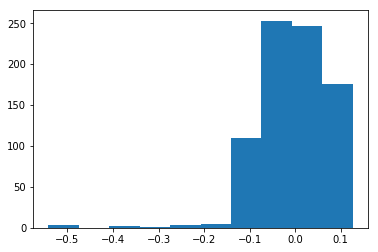

In [154]:
plt.hist(xf1-xf2)

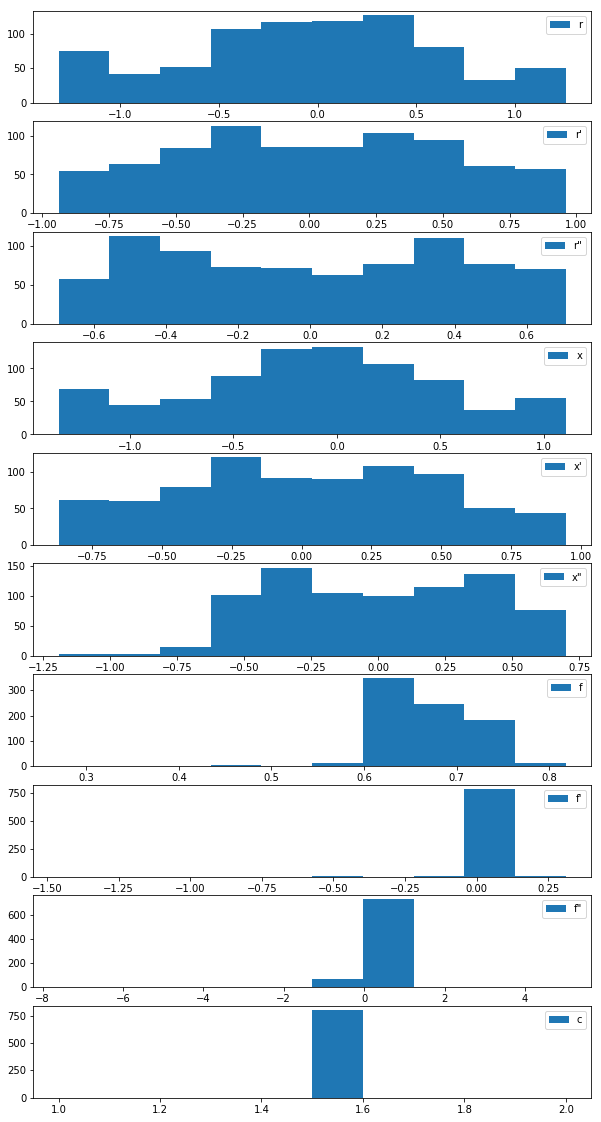

In [82]:
# Examine the range of the input features
fig, ax = plt.subplots(ftr_vecs.shape[1],1, figsize=(10,20))
for i in range(ftr_vecs.shape[1]):
    ax[i].hist(ftr_vecs[:,i], label=ftr_labels[i])
    ax[i].legend()

In [38]:
plt_sol_chosen = plt_sol#[2:5,:]
# plt_sol_chosen[:, -2-n_w:-2]=0.5; plt_sol_chosen[:, 0:n_w]=0.5
# plt_sol_chosen[:, 2*n_w:3*n_w]=0.5;


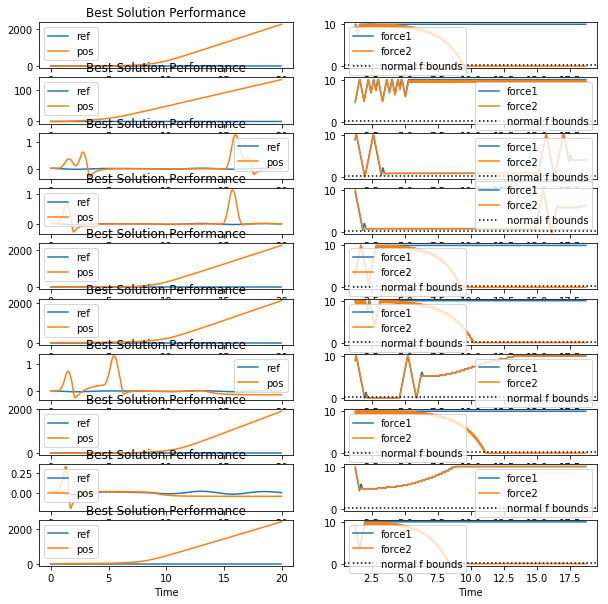

In [39]:
# Select 10 random solutions from the top cluster
# solutions = copy.deepcopy(hofparams[hof_labels==2])
# solutions[:,-2:] = ((solutions[:,-2:] -0.5)*5/traj_max_amp)+0.5
plt_sol = plt_sol_chosen#solutions[np.random.randint(solutions.shape[0], size=10),:]
# plt_sol = solutions[8:10,:]
n_sol = len(plt_sol)
fig, ax = plt.subplots(n_sol, 2, figsize=(10,n_sol))
for i in range(n_sol):   
    tt1, xf1, xf2, xpos, xref = simultest(plt_sol[i], 20, verbose=True)
#     tt1, xf1, xf2, xpos, xref = simul(plt_sol[i], verbose=True)

    t_win = int(len(tt1)/16); pltslc = slice(t_win*1,t_win*(-1))
#     ax[i].plot(time1, 5*xf1, label='5*force')
    ax[i,0].plot(tt1, xref, label='ref')
    ax[i,0].plot(tt1, xpos, label='pos')
    ax[i,1].plot(tt1[pltslc], xf1[pltslc], label='force1')
    ax[i,1].plot(tt1[pltslc], xf2[pltslc], label='force2')
    ax[i,1].axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f bounds')
    ax[i,0].set_title('Best Solution Performance')
for _,axij in np.ndenumerate(ax):
        axij.legend(); axij.set_xlabel('Time')

Clustering Error (Bayesian information criterion) =  -1474222.30


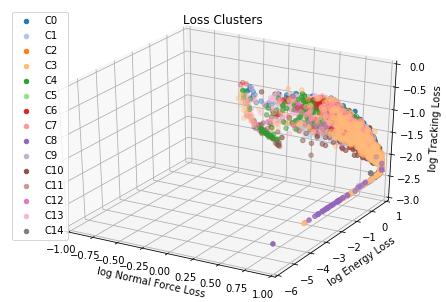

In [41]:
# Clustering
n_clusters = 15

GMhof1 = GaussianMixture(n_clusters, covariance_type='full', tol=0.001, 
                           reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', 
                           weights_init=None, means_init=None, precisions_init=None, 
                           random_state=None, warm_start=False, verbose=0, verbose_interval=10)

GMhof1.fit(hofparams_t)
print("Clustering Error (Bayesian information criterion) = ",\
      '{:.2f}'.format(GMhof1.bic(hofparams_t)))
hof_labels = GMhof1.predict(hofparams_t)

plot_cluster_hofloss(loghofloss, hof_labels, n_clusters, mode='log')


#### Clustering based on loss and parameters

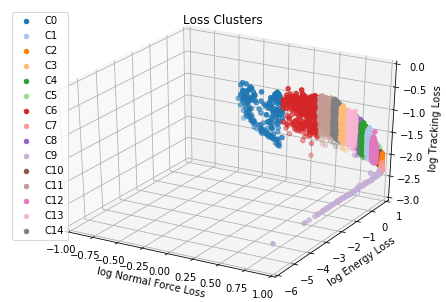

In [42]:
n_clusters = 15
KMhof1 = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=100, verbose=0, 
                         compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, 
                         init_size=None, n_init=3, reassignment_ratio=0.01)

KMhof1.fit(hofcat)
# print("Clustering Error (Bayesian information criterion) = ",\
#       '{:.2f}'.format(KMhof1.bic(hofparams_t)))
hof_labels = KMhof1.predict(hofcat)

plot_cluster_hofloss(loghofloss, hof_labels, n_clusters, mode='log')

Clustering Error (Bayesian information criterion) =  -1453442.69


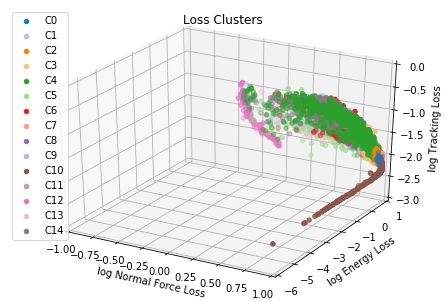

In [15]:
n_clusters = 15
GMhof = GaussianMixture(n_components=n_clusters, covariance_type='full', tol=0.001, 
                           reg_covar=1e-06, max_iter=200, n_init=1, init_params='kmeans', 
                           weights_init=None, means_init=None, precisions_init=None, 
                           random_state=None, warm_start=False, verbose=0, verbose_interval=10)
GMhof.fit(hofcat)
print("Clustering Error (Bayesian information criterion) = ",\
      '{:.2f}'.format(GMhof.bic(hofcat)))
hofcat_labels = GMhof.predict(hofcat)
plot_cluster_hofloss(loghofloss, hofcat_labels, n_solcomponents, mode='log')

#### Visualize weights of a cluster

In [16]:
i_cl = 12; n_components=0.9; cl_data = 
cl = hofparams_t[hofcat_labels==i_cl]
solutions = hofparams[hofcat_labels==i_cl]
PCA_cl = PCA(n_components=n_components, svd_solver = 'full')
PCA_cl.fit(cl)
print('Cluster ', i_cl, ', containing ', len(cl),' solutions decomposed into ', PCA_cl.n_components_, ' components.')
print("Decomposition Score (average log-likelihood of all samples) = ",\
      '{:.2f}'.format(PCA_cl.score(cl)))

Cluster  12 , containing  107  solutions decomposed into  9  components.
Decomposition Score (average log-likelihood of all samples) =  95.38


explained_variance_ratio:  [0.4178 0.2154 0.1192 0.0744 0.0579 0.04   0.0298 0.0206 0.0132 0.009 ]


Text(0.5, 1.0, 'Building Components of the Evolved Agent Params')

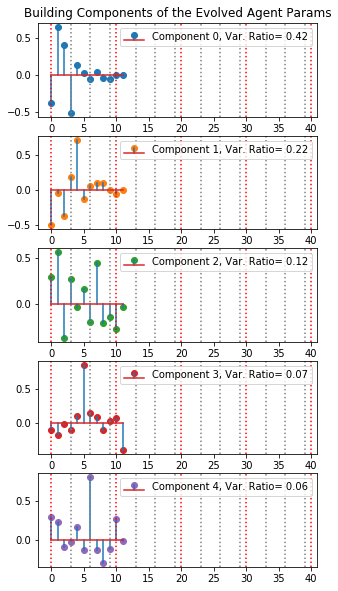

In [50]:
np.set_printoptions(precision=4)
print('explained_variance_ratio: ', PCA_cl.explained_variance_ratio_)
cmap = plt.get_cmap("tab10")
n_plt=5
fig, ax = plt.subplots(n_plt, figsize=(5,n_plt*2))
for i in range(n_plt):
    ax[i].stem(PCA_cl.components_[i], markerfmt='C'+str(i)+'o', label='Component '+str(i)
               +', Var. Ratio= '+'{:.2f}'.format(PCA_cl.explained_variance_ratio_[i]))
    ax[i].legend()
    # Split the coefs
    for pt in split_points:
        if pt%n_w==0:
            ax[i].axvline(x=pt, ls=':', c='red')
        else:
            ax[i].axvline(x=pt, ls=':', c='gray')
ax[0].set_title('Building Components of the Evolved Agent Params')



#### Examine the solutions in the top cluster

In [36]:
# Select 10 random solutions from the top cluster
solutions = copy.deepcopy(hofparams[hofcat_labels==1])
# solutions[:,-2:] = ((solutions[:,-2:] -0.5)*5/traj_max_amp)+0.5
plt_sol = solutions[np.random.randint(solutions.shape[0], size=10),:]
# plt_sol = solutions[8:10,:]
n_sol = len(plt_sol)
fig, ax = plt.subplots(n_sol, 2, figsize=(10,n_sol))
for i in range(n_sol):   
    tt1, xf1, xf2, xpos, xref = simultest(plt_sol[i], 20, verbose=True)
#     tt1, xf1, xf2, xpos, xref = simul(plt_sol[i], verbose=True)

    t_win = int(len(tt1)/16); pltslc = slice(t_win*1,t_win*(-1))
#     ax[i].plot(time1, 5*xf1, label='5*force')
    ax[i,0].plot(tt1, xref, label='ref')
    ax[i,0].plot(tt1, xpos, label='pos')
    ax[i,1].plot(tt1[pltslc], xf1[pltslc], label='force1')
    ax[i,1].plot(tt1[pltslc], xf2[pltslc], label='force2')
    ax[i,1].axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f bounds')
    ax[i,0].set_title('Best Solution Performance')
for _,axij in np.ndenumerate(ax):
        axij.legend(); axij.set_xlabel('Time')

NameError: name 'hofcat_labels' is not defined

In [54]:
param2th(solutions[-1,-2:])
# solutions[-1,-2:]

array([-0.0077,  0.0056])

<a id='analyses'></a>
## Analyze the solutions

Set the pltslc varibale to see different slices

loss =  (0.0070988851711315405, 0.48935024906026314, 9.057523583806818)


Text(0.5, 1.0, 'Best Solution Performance')

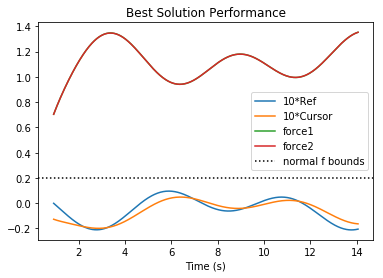

In [75]:
sol = solutions[1]
print("loss = ", simul(sol, verbose=False))
tt1, xf1, xf2, xpos, xref = simul(sol, verbose=True)

fig, ax = plt.subplots()

t_win = int(len(tt1)/16)
pltslc = slice(t_win*1,t_win*(-1))
    

xacc = np.diff(xpos, n=2, prepend=[0,0])/tstep

ax.plot(tt1[pltslc], 10*xref[pltslc], label='10*Ref')
ax.plot(tt1[pltslc], 10*xpos[pltslc], label='10*Cursor')
# ax.plot(tt1[pltslc], 1*xacc[pltslc], label='1*X acc')
ax.plot(tt1[pltslc], xf1[pltslc], label='force1')
ax.plot(tt1[pltslc], xf2[pltslc], label='force2')
# ax.plot(tt1[pltslc], 1*(xf1-xf2)[pltslc], '--',label='1*net force')
ax.axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f bounds')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_title('Best Solution Performance')
# pert_spec = [[0.01, 0.17, 0.3], [0.02, 0.5, 1.1]]
# pert_spec = [[0.1, 0.17, 0.3], [0.2, 0.5, 1.1]]

# time1, pert = trajectory_generator(tstep, duration, traj_spec=pert_spec)
# plt.plot(pert)


In [133]:
# np.save('data/EAsol(v3)_42params_stablesolution5',solutions[0])
# solutions = np.load('data/EAsol(v3)_42params_stablesolution.npy')
# solutions = [solutions, [1]]

In [134]:
params = solutions[0]
agent1w1 = param2w(params[:n_w])
agent1w2 = param2w(params[n_w: 2*n_w])

agent2w1 = param2w(params[2*n_w:3*n_w])
agent2w2 = param2w(params[3*n_w: 4*n_w])

#     agent1fth = param2th(paramset[4*n_w])
agent1th = param2th(params[4*n_w])
agent2th = param2th(params[4*n_w+1])
print('agent1th=', agent1th)
print('agent1w1=', agent1w1)
print('agent1w2=', agent1w2)
print('--------------')
print('agent2th=', agent2th)
print('agent2w1=', agent2w1)
print('agent2w2=', agent2w2)

agent1th= 0.5104295486399124
agent1w1= [ 0.05929636  0.01136868 -0.25437066 -0.09120991  0.03712758 -0.01140605
  0.3419305  -0.15223127 -0.38044853  0.65658075]
agent1w2= [ 0.51087598  0.16768944  0.32193993 -0.41810334 -0.02809006 -0.18940586
 -0.09567432 -0.01522276  0.03264128  0.02537519]
--------------
agent2th= 0.0015644090365851682
agent2w1= [ 0.05587869 -0.05287102 -0.00089726 -0.01745012  0.20342503 -0.00802647
 -0.3275505   0.10715349  0.02946258  0.51812026]
agent2w2= [-0.03297894  0.05606801  0.05783447 -0.49025247  0.01677059 -0.0882553
 -0.01618683  0.10159209  0.30395534  0.21050051]


In [135]:
# traj_spec = [[1, 0.3,1.3], [4, 0.2,0], [0.5,0.9,1], [0.2,1.5,0.5], [0.5, 0.21,1.3]]
# time1, traj = trajectory_generator(tstep, duration, traj_spec=traj_spec)
# # tt1, xf1, xf2, xpos = simul(agent1w, agent2w, verbose=True)
# tt1, xf1, xf2, xpos = simul(params, verbose=True)

# fig, ax = plt.subplots()
# ax.plot(tt1, xpos, label='Cursor')
# ax.plot(tt1, traj, label='Ref')
# ax.plot(tt1, 5*(xf1-xf2), '--g',label='5*net force')

# # ax.plot(tt1, 10*xf2, '--y',label='10*force2')
# ax.set_xlabel('Time (s)')
# ax.set_title('Best Solution Performance')

# ax.legend()

In [136]:
evalState(params)

(0.003924758858882418, 0.5855008730440735, 7.983020286232925)

### Sensitivity Analysis

find $\frac{\partial f}{\partial p_i}|_{solution}$ with $\partial p_i=0.005$ for 10 steps.

In [137]:
def simul_0(paramset):
    return simul(paramset)[0]
def simul_1(*args):
    return simul(paramset)[1]
dfun = ndiff.Gradient(simul_0, step=0.2, method='central', order=2, n=1, full_output=False)
# dfun = ndiff.Gradient(np.tanh, step=None, method='central', order=2, n=1, full_output=True)

# def rosen(x): return (1-x[0])**2 + 105.*(x[1]-x[0]**2)**2

# grad = nd.Gradient(rosen)([1, 1])
sns = dfun(params)

In [138]:
for i in range(len(ftr_modules)):
    print(sns[ftr_modules[i][0]: ftr_modules[i][1]])

[ 0.05447356  0.02502565 -0.03716406  0.1865662  -0.2493547   0.15920662]
[-0.03157396 -0.03346292 -0.03531836]
[-0.04422805]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0.]
[ 0.05092673  0.01899392 -0.03380997  0.76886512 -0.62349538  0.64387383]
[1.73204869 1.68491327 1.73165129]
[0.19456201]
[ 0.0037973   0.00491688 -0.00557898]
[0.01020324 0.00619513 0.0519382 ]
[-0.03333696 -0.01831281 -0.03053126]
[-0.01580983]
[-0.08295704 -0.28828879]


### Simulate for testing

Text(0.5, 1.0, 'Best Solution Performance')

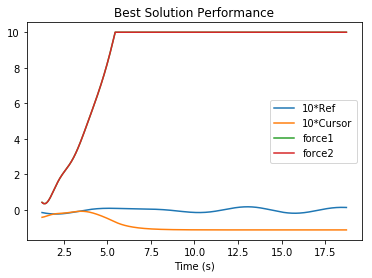

In [119]:
tt1, xf1, xf2, xpos, xref = simultest(hofparams[0,:], 20, verbose=True)


t_win = int(len(tt1)/16)
pltslc = slice(t_win*1,t_win*(-1))
    

xacc = np.diff(xpos, n=2, prepend=[0,0])/tstep
fig, ax = plt.subplots()
ax.plot(tt1[pltslc], 10*xref[pltslc], label='10*Ref')
ax.plot(tt1[pltslc], 10*xpos[pltslc], label='10*Cursor')
# ax.plot(tt1[pltslc], 100*xacc[pltslc], label='100*X acc')
ax.plot(tt1[pltslc], xf1[pltslc], label='force1')
ax.plot(tt1[pltslc], xf2[pltslc], label='force2')
# ax.axhline(y=egg_bnd[0], ls=':', color='k',  label='normal f bounds')
plt.legend()
# plt.plot(tt1, 1*xf2, '--y',label='1*disturbance')
plt.xlabel('Time (s)')
plt.title('Best Solution Performance')

In [45]:
simultest(solutions[1], 20, verbose=False)

(0.011378241456363535, 0.8676584900684342, 7.662940430725414)